In [1]:
import scipy
import json
import os
import numpy as np

import pandas as pd
import seaborn as sns
import scipy.stats
import statsmodels.api as sm

import matplotlib.pyplot as plt

from scipy.signal import correlate
from statsmodels.tsa.stattools import ccf

# Figure Height:width Ratio

In [2]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [3]:
GENERAL_RATIO = set_size(width='thesis', fraction=3.0)
SPECIAL_RATIO = set_size(width='thesis', fraction=5.0)

Y_LABEL_FONT = 13
X_LABEL_FONT = 13
TITLE_FONT = 15
ANOT_FONT = 10

# 1. Common Functions

In [4]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str
):
    '''Loads json file (attack results) and csv files (Shapley, LOO)
    into a one pandas dataframe'''
    
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    alpha_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_alpha.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    alpha_frame = pd.read_csv(alpha_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[loo_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[loo_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
        
        # Loads Alpha values
        array = alpha_frame[alpha_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_ALPHA_ACC'] = array
        array = alpha_frame[alpha_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_ALPHA_F1SCORE'] = array
    
    return dataframe

In [5]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str
):
    '''Loads json file (attack results) and csv files (Shapley, LOO)
    into a one pandas dataframe'''
    
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    alpha_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_alpha.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    alpha_frame = pd.read_csv(alpha_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[loo_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[loo_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
        
        # Loads Alpha values
        array = alpha_frame[alpha_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_ALPHA_ACC'] = array
        array = alpha_frame[alpha_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_ALPHA_F1SCORE'] = array
    
    return dataframe

In [6]:
def load_multiple_contribution_attack_results(
    scenarios: list[str],
    versions: list[str],
    datasets: list[str]
):
    all_results = {
        f"{scenario}_{version}_{dataset}" : None
        for scenario in scenarios
        for version in versions
        for dataset in datasets
    }
    for scenario in scenarios:
        for version in versions:
            for dataset in datasets:
                key = f"{scenario}_{version}_{dataset}"
                all_results[key] = load_single_contribution_attack_results(
                    scenario=scenario,
                    version=version,
                    dataset=dataset
                    )
    return all_results

In [7]:
def calculate_single_corr(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    # Calculates TPR-SHAP CORR
    for client in range(no_clients):
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        
        # Calculates TPR-LOO SHAP
        corr_frame.loc[client, 'TPR_TO_LOO_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_LOO_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_F1SCORE']
        ).statistic
        
        # Calculates TPR-ALPHA SHAP
        corr_frame.loc[client, 'TPR_TO_ALPHA_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_ALPHA_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_ALPHA_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_ALPHA_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_ALPHA_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_ALPHA_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_ALPHA_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_ALPHA_F1SCORE']
        ).statistic
    return corr_frame

In [8]:
def calculate_single_stationarity(
    no_clients: int,
    frame: pd.DataFrame,
):
    statio_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        tpr_results = sm.tsa.stattools.adfuller(frame[f'{client}_TPR'])
        shap_results = sm.tsa.stattools.adfuller(frame[f'{client}_SHAP_F1SCORE'])
        loo_results = sm.tsa.stattools.adfuller(frame[f'{client}_LOO_F1SCORE'])
        alpha_results = sm.tsa.stattools.adfuller(frame[f'{client}_ALPHA_F1SCORE'])
        
        statio_frame.loc[client, 'TPR ADF Statistic'] = tpr_results[0]
        statio_frame.loc[client, 'TPR ADF p-value'] = tpr_results[1]
        statio_frame.loc[client, 'SHAP ADF Statistic'] = shap_results[0]
        statio_frame.loc[client, 'SHAP ADF p-value'] = shap_results[1]
        statio_frame.loc[client, 'LOO ADF Statistic'] = loo_results[0]
        statio_frame.loc[client, 'LOO ADF p-value'] = loo_results[1]
        statio_frame.loc[client, 'ALPHA ADF Statistic'] = alpha_results[0]
        statio_frame.loc[client, 'ALPHA ADF p-value'] = alpha_results[1]
        
    return statio_frame

In [9]:
def calculate_single_corr_short(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        for metric in ['SHAP', 'LOO', 'ALPHA']:
            corr = correlation(
                frame[f'{client}_TPR'],
                frame[f'{client}_{metric}_ACC']
            )
            corr_frame.loc[client, f'TPR_TO_{metric}_ACC CORR'] = corr.statistic
            corr_frame.loc[client, f'TPR_TO_{metric}_ACC P-VALUE'] = corr.pvalue
            
            corr = correlation(
                frame[f'{client}_TPR'],
                frame[f'{client}_{metric}_F1SCORE']
            )
            corr_frame.loc[client, f'TPR_TO_{metric}_F1SCORE'] = corr.statistic
            corr_frame.loc[client, f'TPR_TO_{metric}_F1SCORE P-VALUE'] = corr.pvalue
        
    return corr_frame

In [10]:
def calculate_single_crosscor(
    no_clients: int,
    no_round: int,
    frame: pd.DataFrame,
    shift: int
):
    crosscorr_frame = pd.DataFrame(index=range(no_round * 2 - 1), columns=[f"client_{client}" for client in range(no_clients)])
    
    for client in range(no_clients):
        series_X = frame[f'{client}_TPR']
        series_Y = np.roll(frame[f'{client}_SHAP_ACC'], shift=shift)
        crosscorr_frame[f"client_{client}"] = np.array(correlate(series_X - np.mean(series_X), series_Y - np.mean(series_Y), mode="full"))
    
    return crosscorr_frame

In [11]:
def calculate_multiple_stationarity(
    results : dict,
    no_clients : int,
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_stationarity(frame=frame, no_clients=no_clients)
    return all_results

In [12]:
def calculate_multiple_corr(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [13]:
def calculate_multiple_corr_short(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr_short(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [14]:
def calculate_multiple_stat(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [15]:
def calculate_multiple_crosscorr(
    results : dict,
    no_clients : int,
    no_round : int,
    shift : int
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_crosscor(frame=frame, no_clients=no_clients, no_round=no_round, shift=shift)
    return all_results

In [16]:
def calculate_single_pvalue(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_ACC']
        ).pvalue
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_F1SCORE']
        ).pvalue
        
        corr_frame.loc[client, 'TPR_TO_LOO_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_ACC']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_LOO_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_ACC']
        ).pvalue
        corr_frame.loc[client, 'TPR_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_F1SCORE']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_F1SCORE']
        ).pvalue
    return corr_frame

In [17]:
def calculate_multiple_pvalues(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_pvalue(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

# Part 4.1.: Visual Inspection of the Relationship (full)

## Part 4.1A (SV)

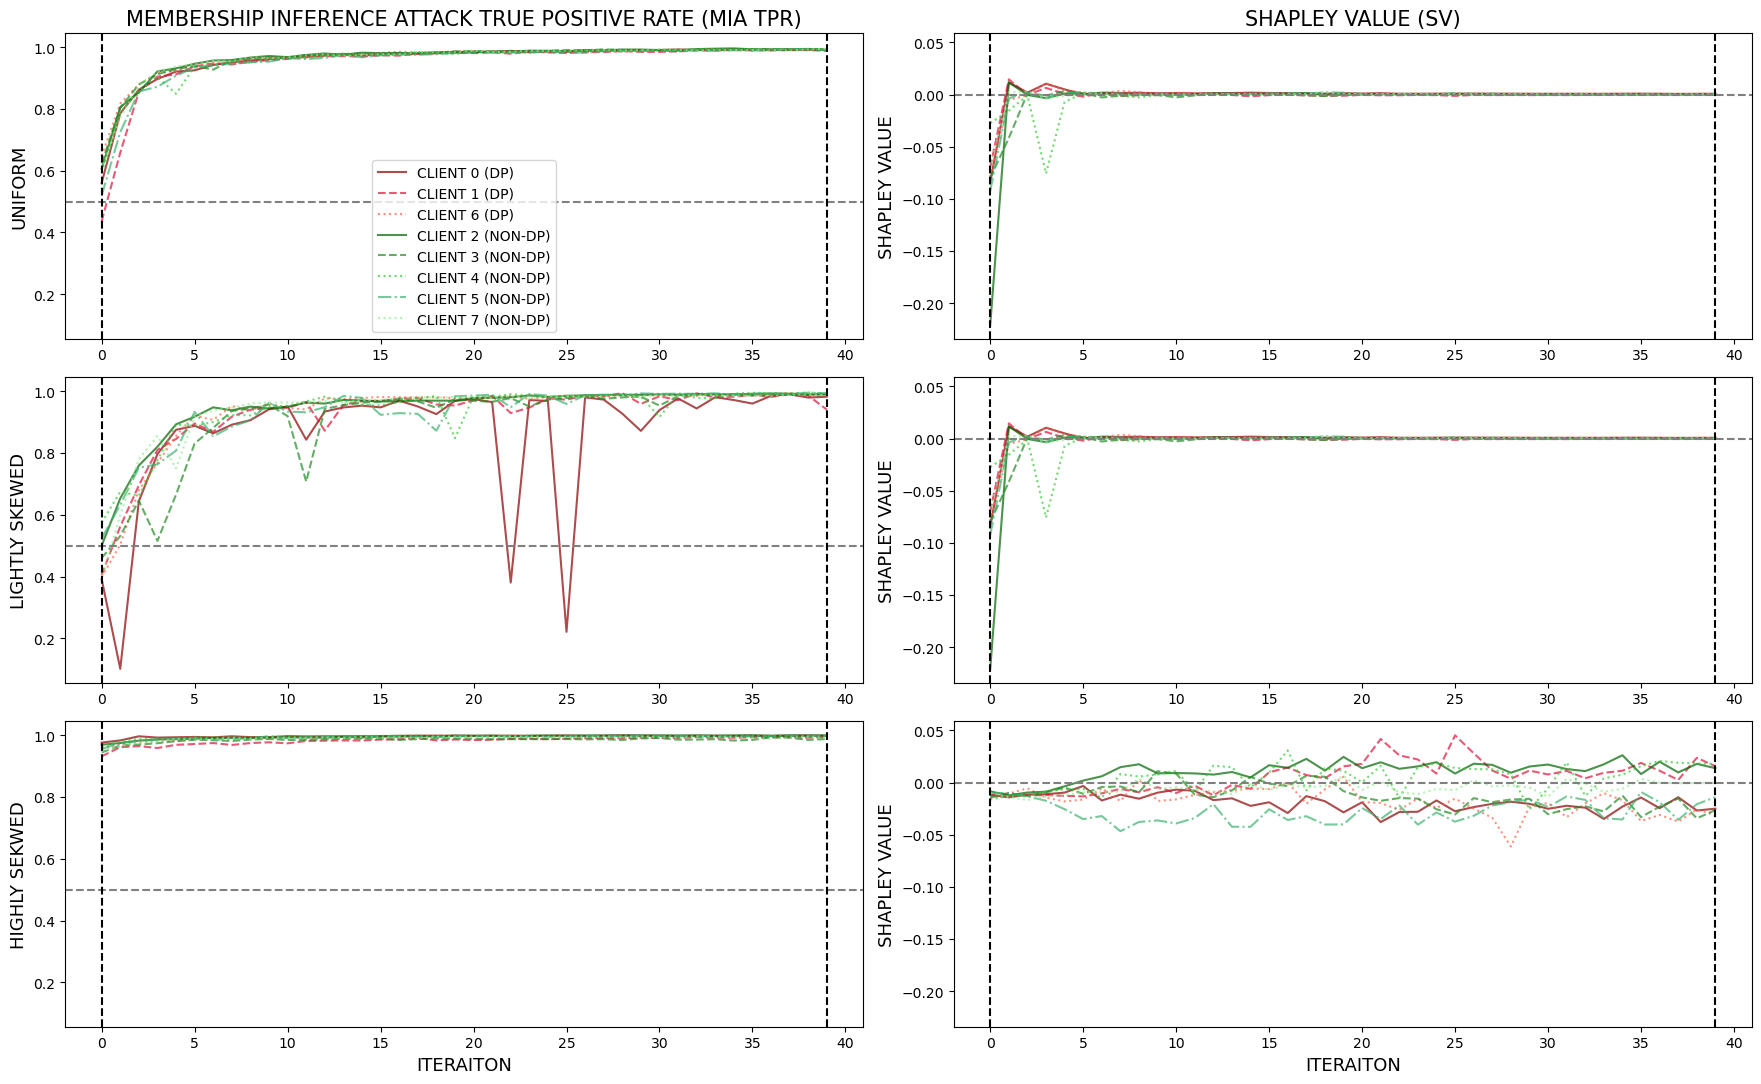

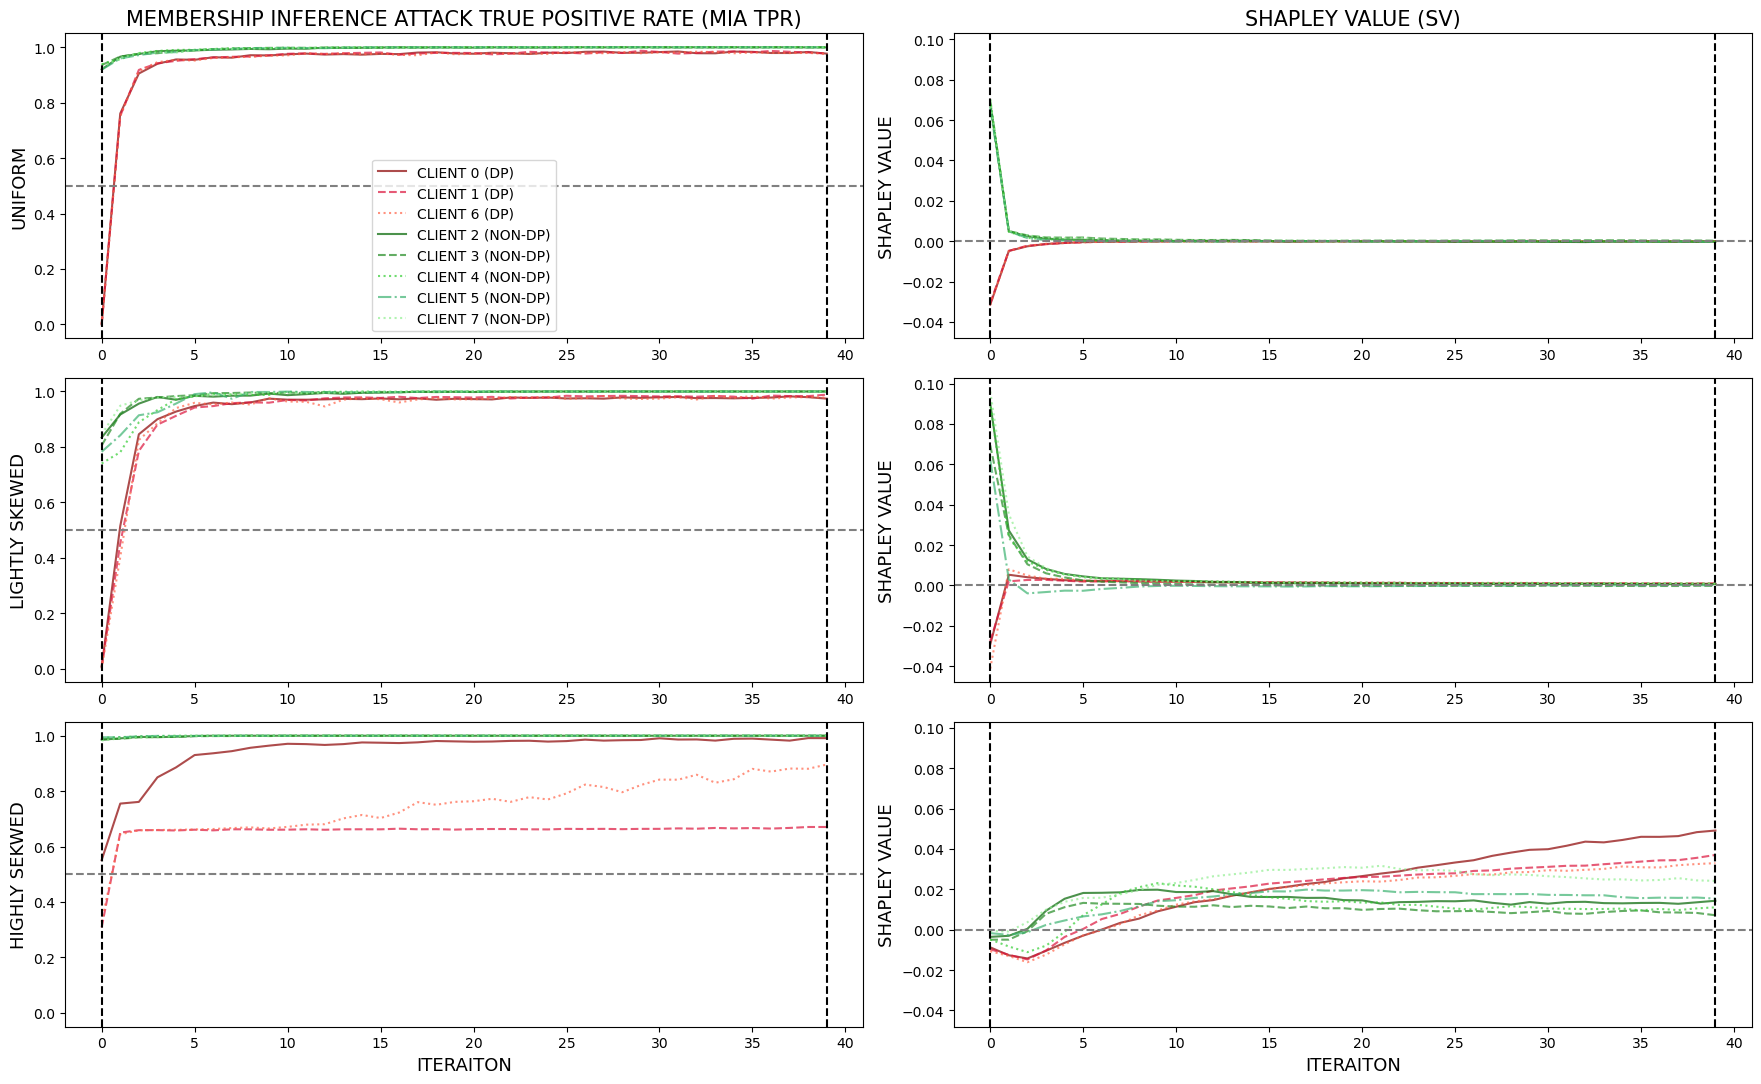

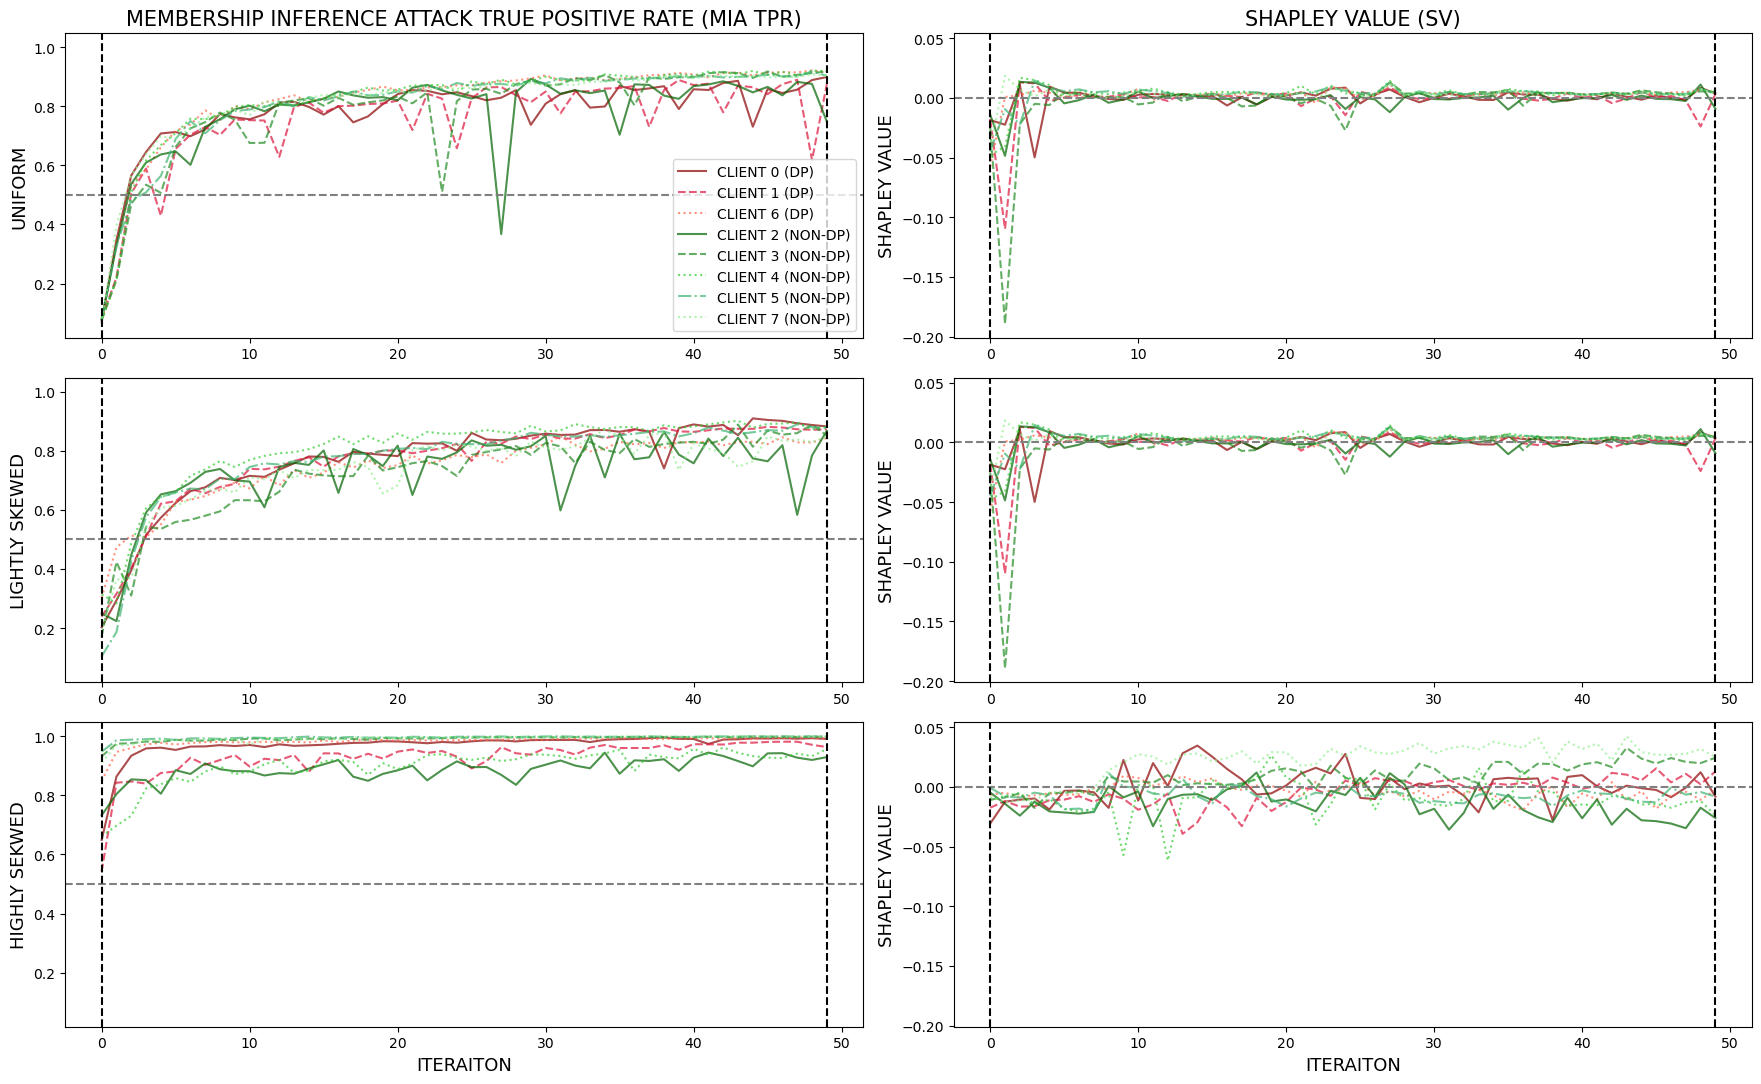

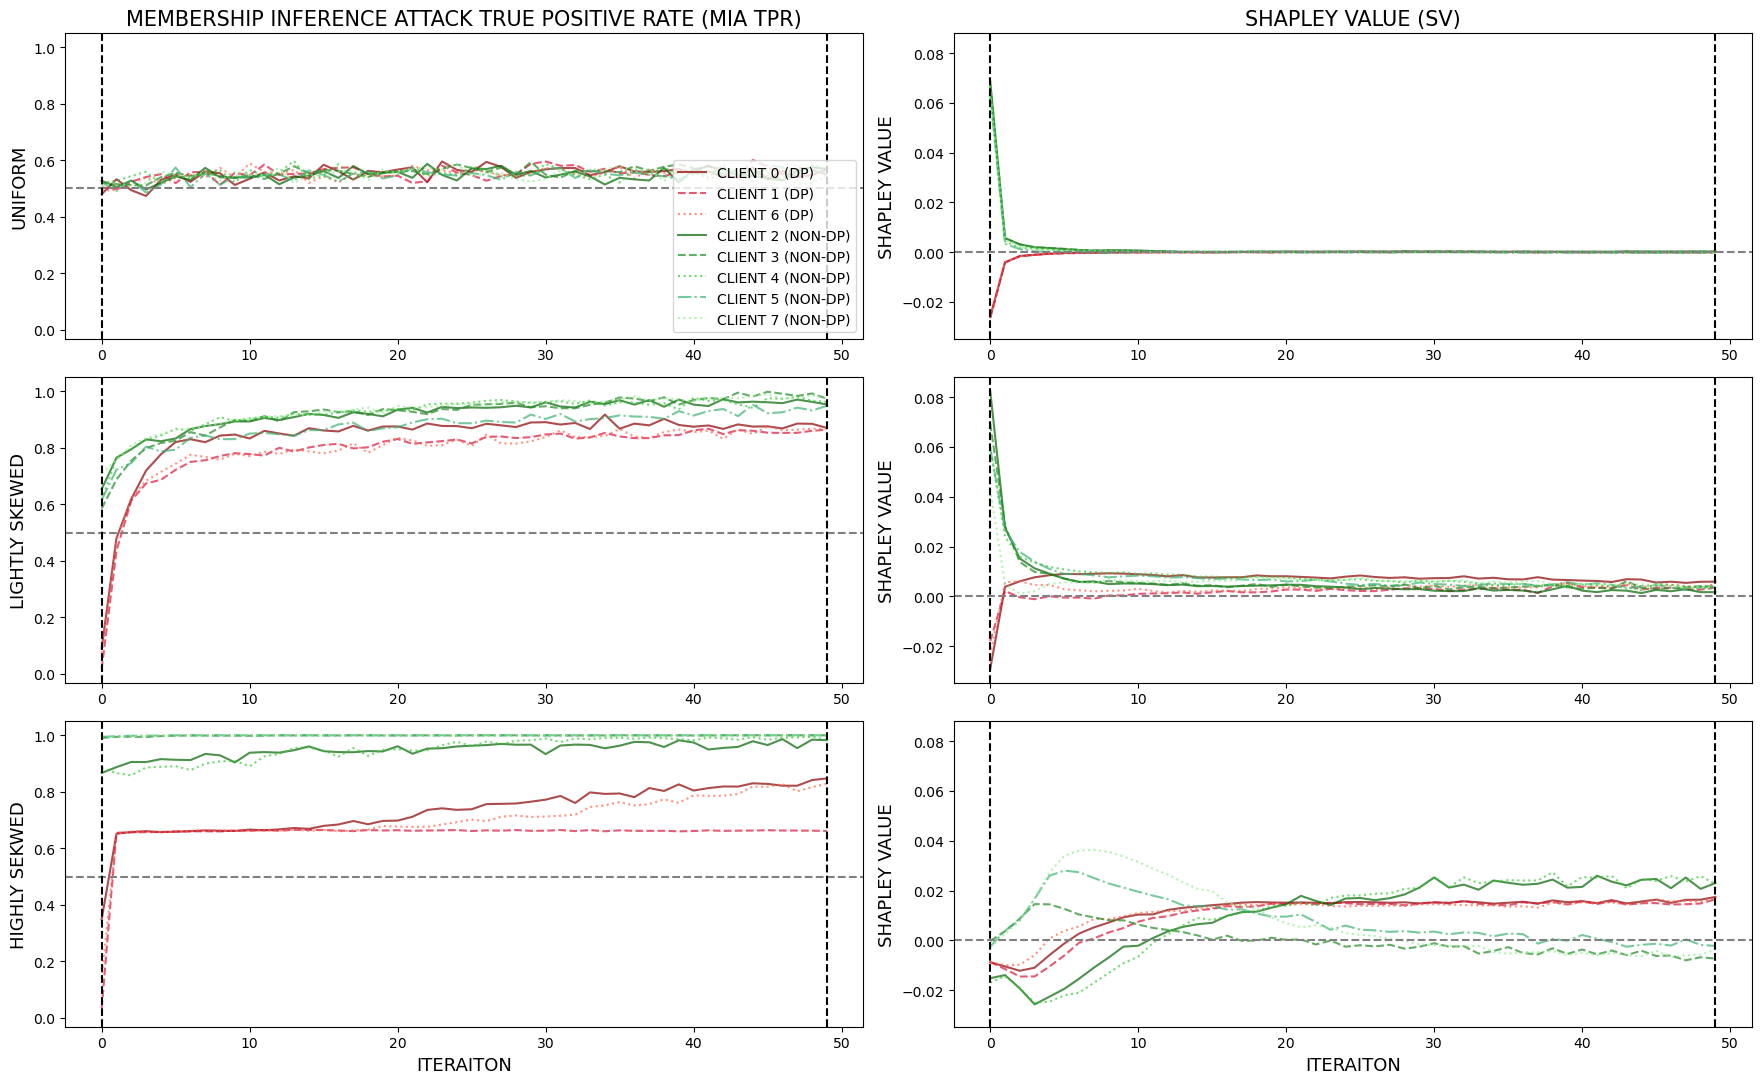

In [18]:
datasets = ['mnist', 'fmnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    1: ('#DC143C', '--'),  # Crimson Red (Dashed)
    6: ('#FF6347', ':'),   # Tomato Red (Dotted)
    2: ('#006400', '-'),   # Dark Green (Solid)
    3: ('#228B22', '--'),  # Forest Green (Dashed)
    4: ('#32CD32', ':'),   # Lime Green (Dotted)
    5: ('#3CB371', '-.'),  # Medium Sea Green (Dash-Dot)
    7: ('#90EE90', ':')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 2, figsize=GENERAL_RATIO)
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 1, 6]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [2, 3, 4, 5, 7]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
    
        axes[0,0].legend()
        axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=TITLE_FONT)
        axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=TITLE_FONT)

        axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=Y_LABEL_FONT)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=Y_LABEL_FONT)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])

        if dataset == 'mnist':
            x = 39
        else:
            x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=X_LABEL_FONT)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=Y_LABEL_FONT)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)
        fig.tight_layout()

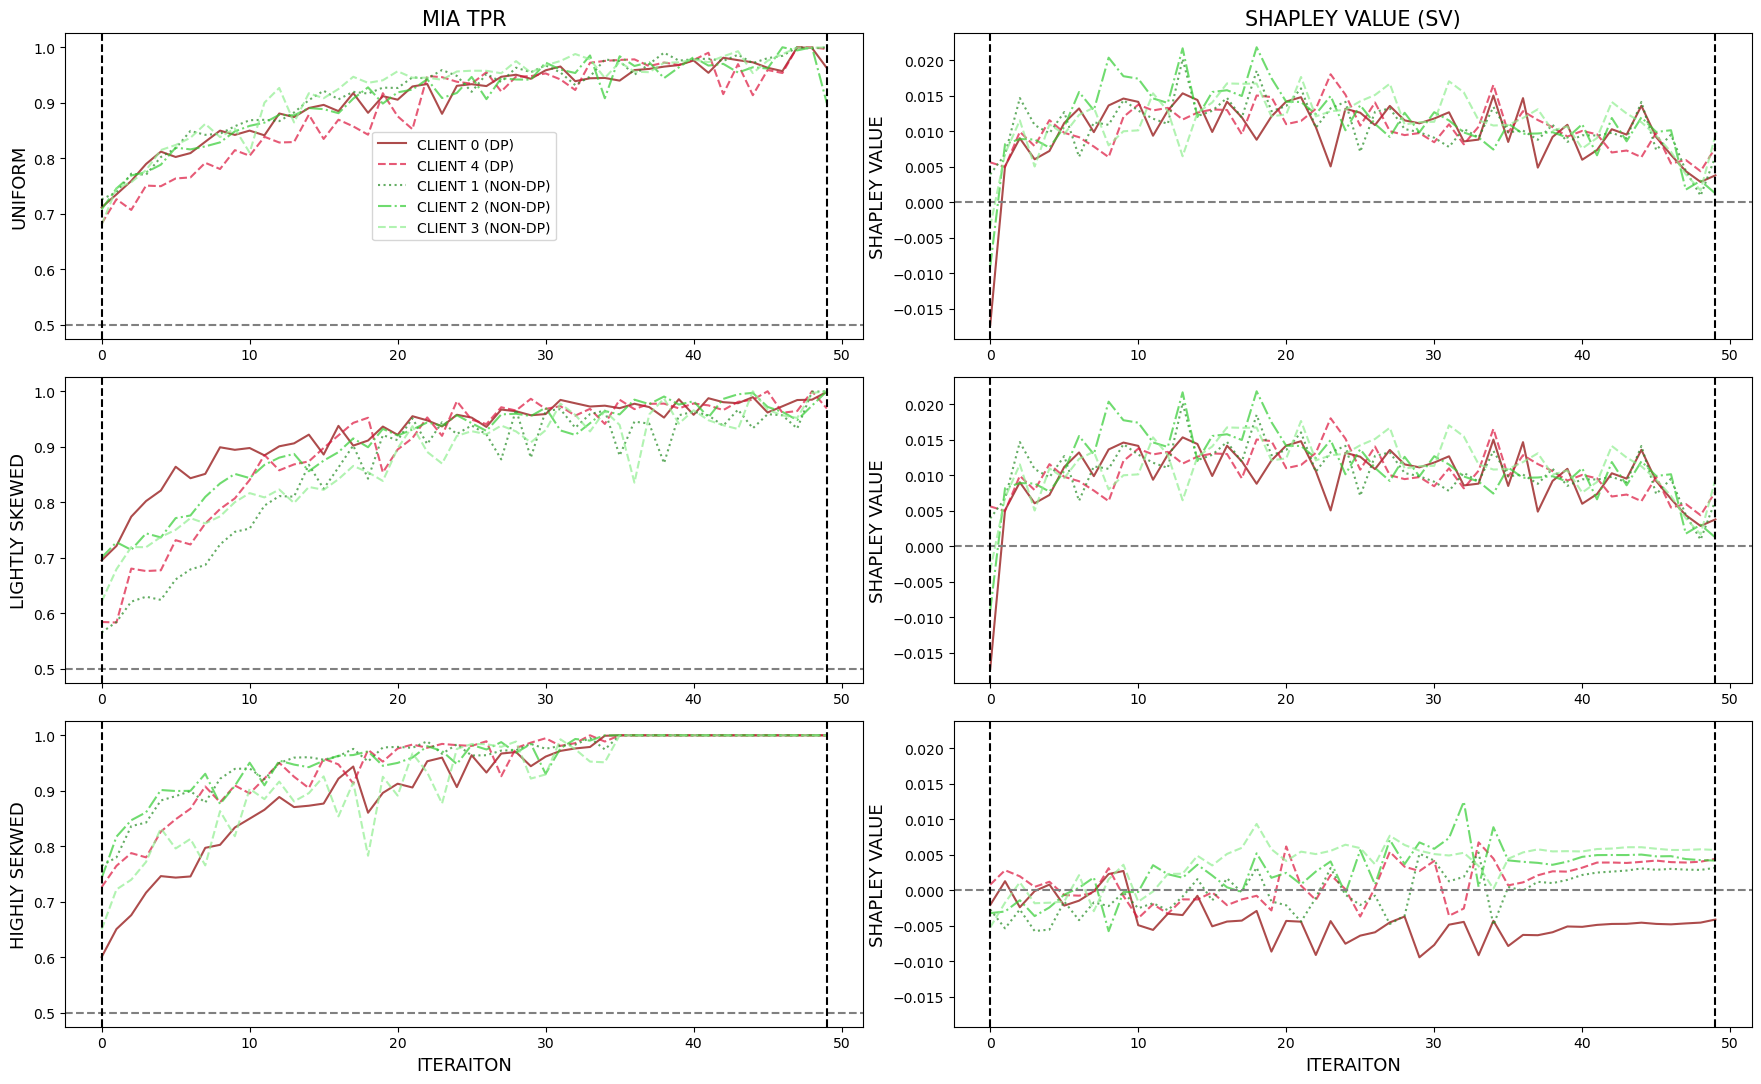

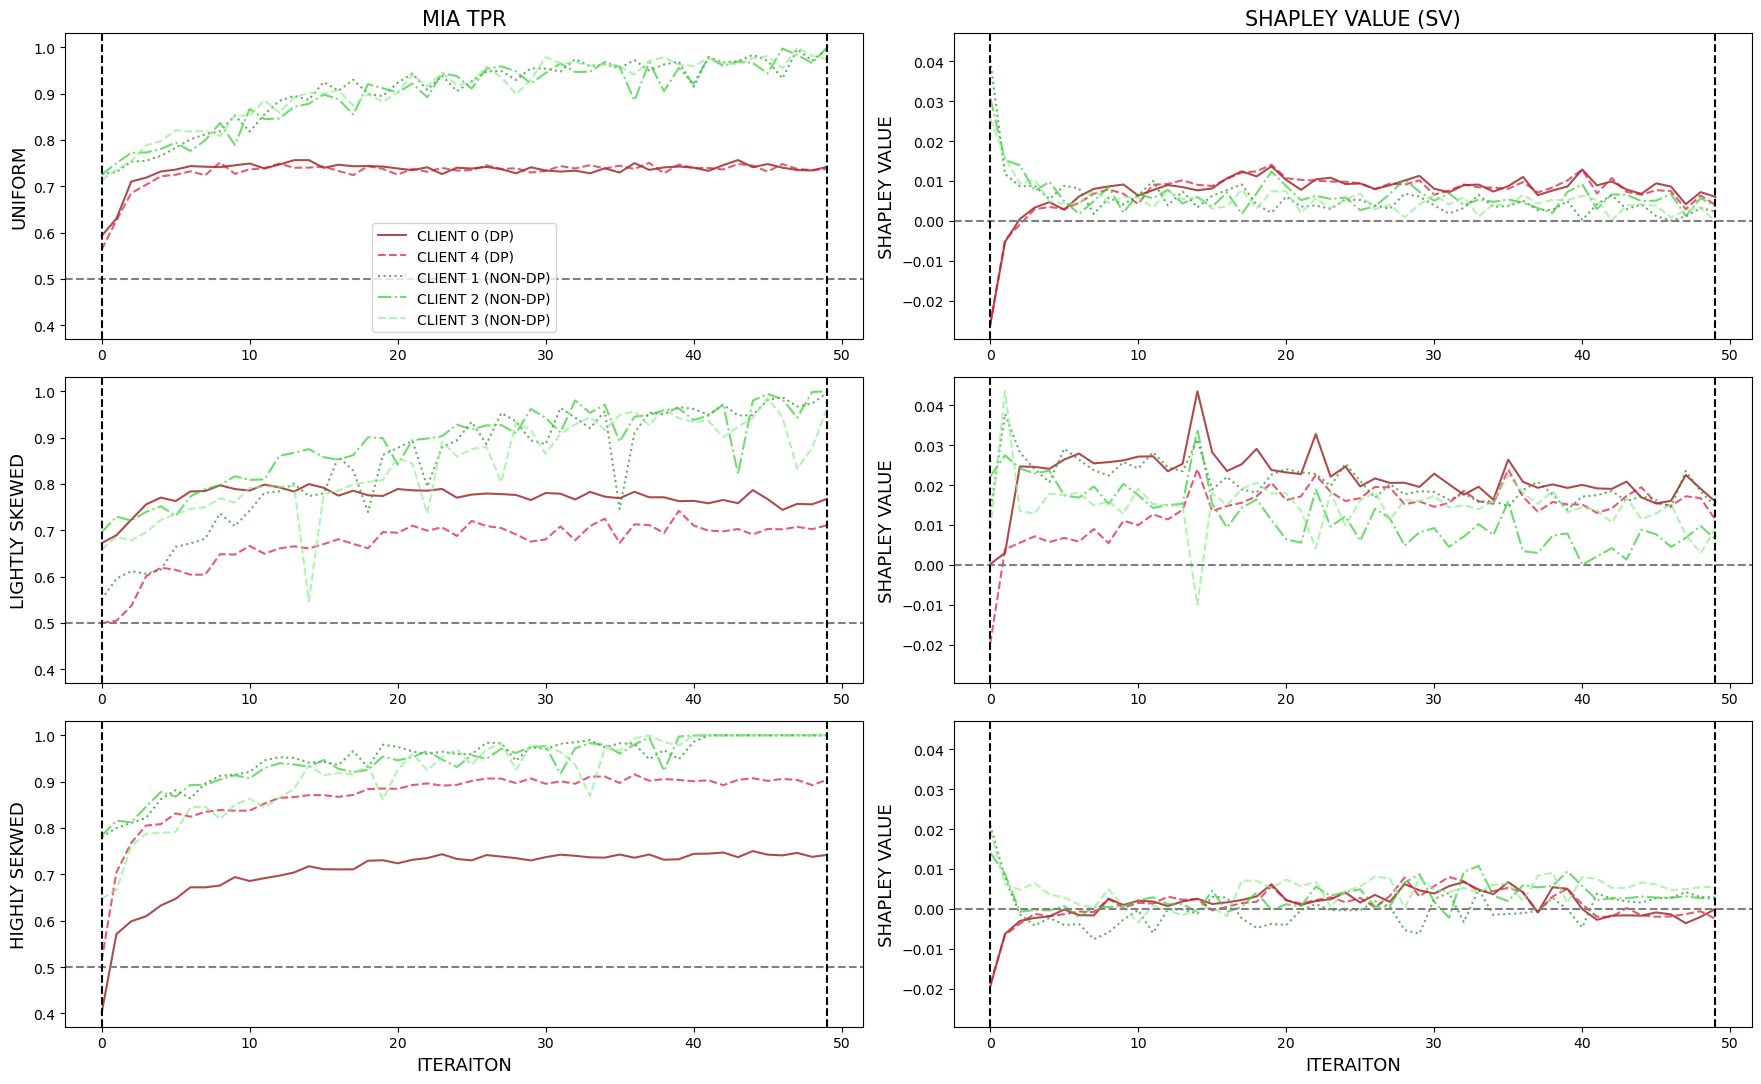

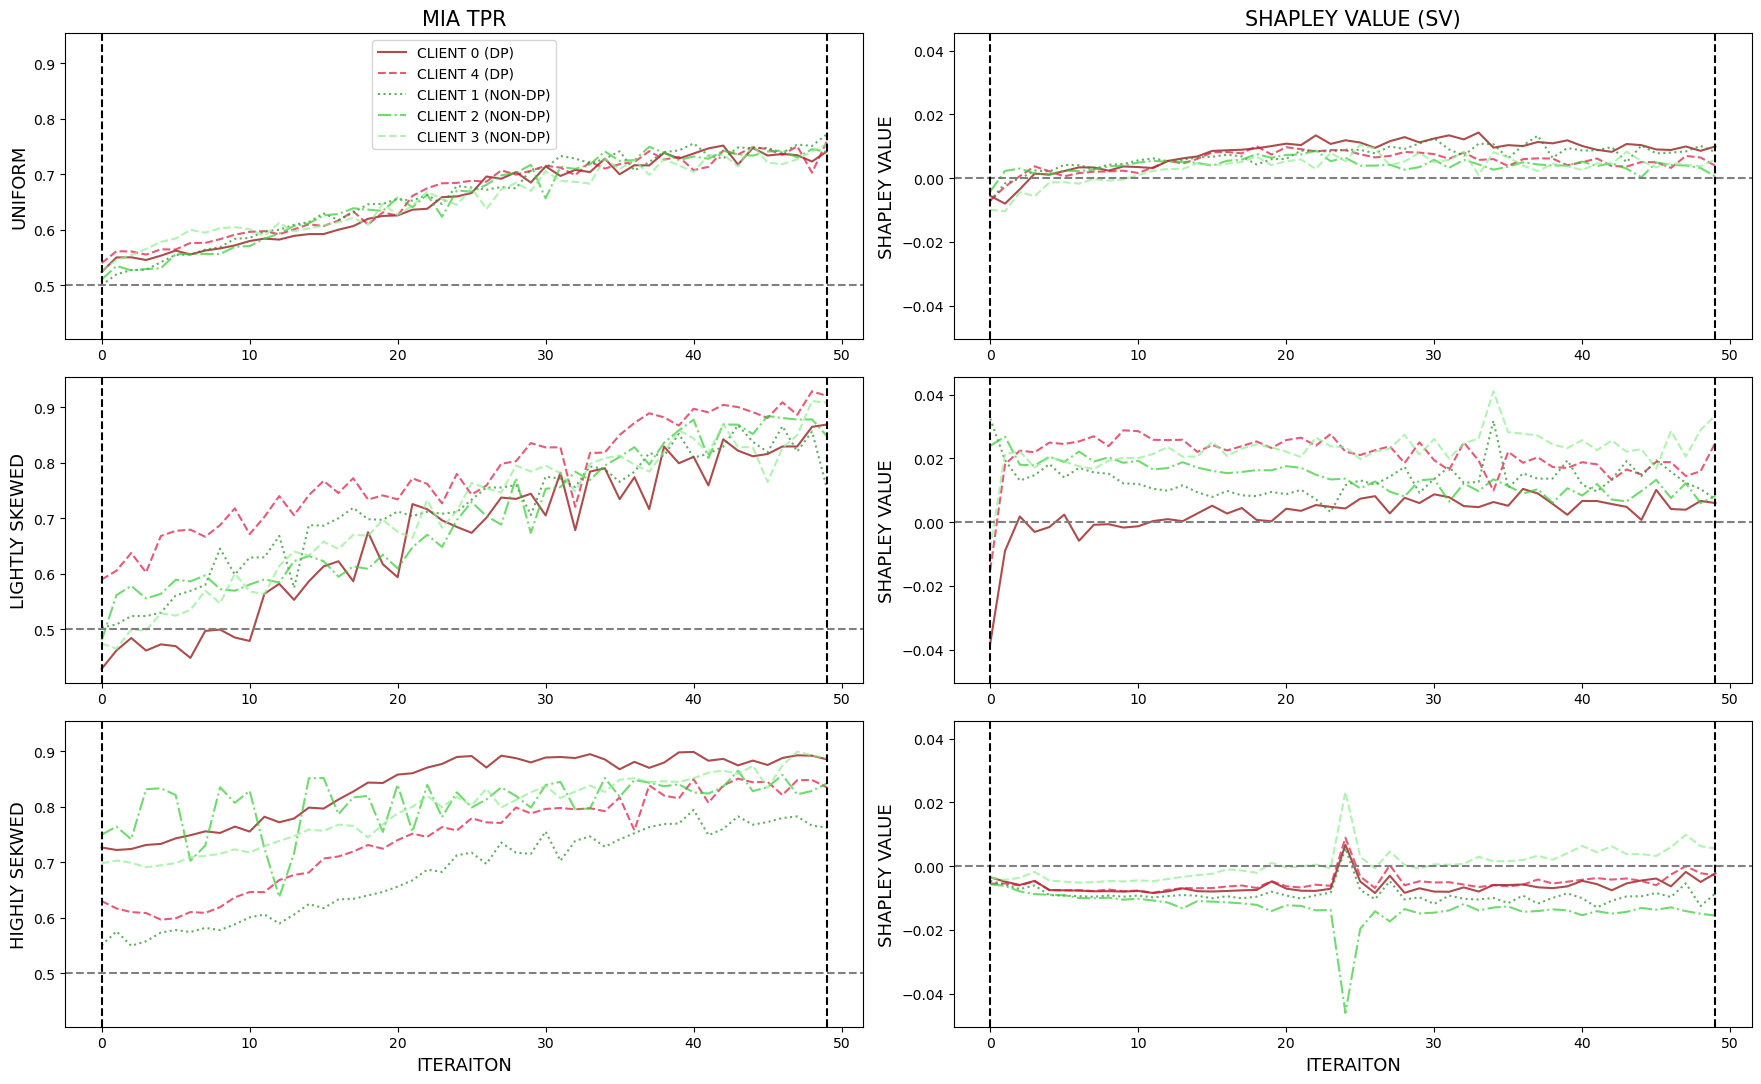

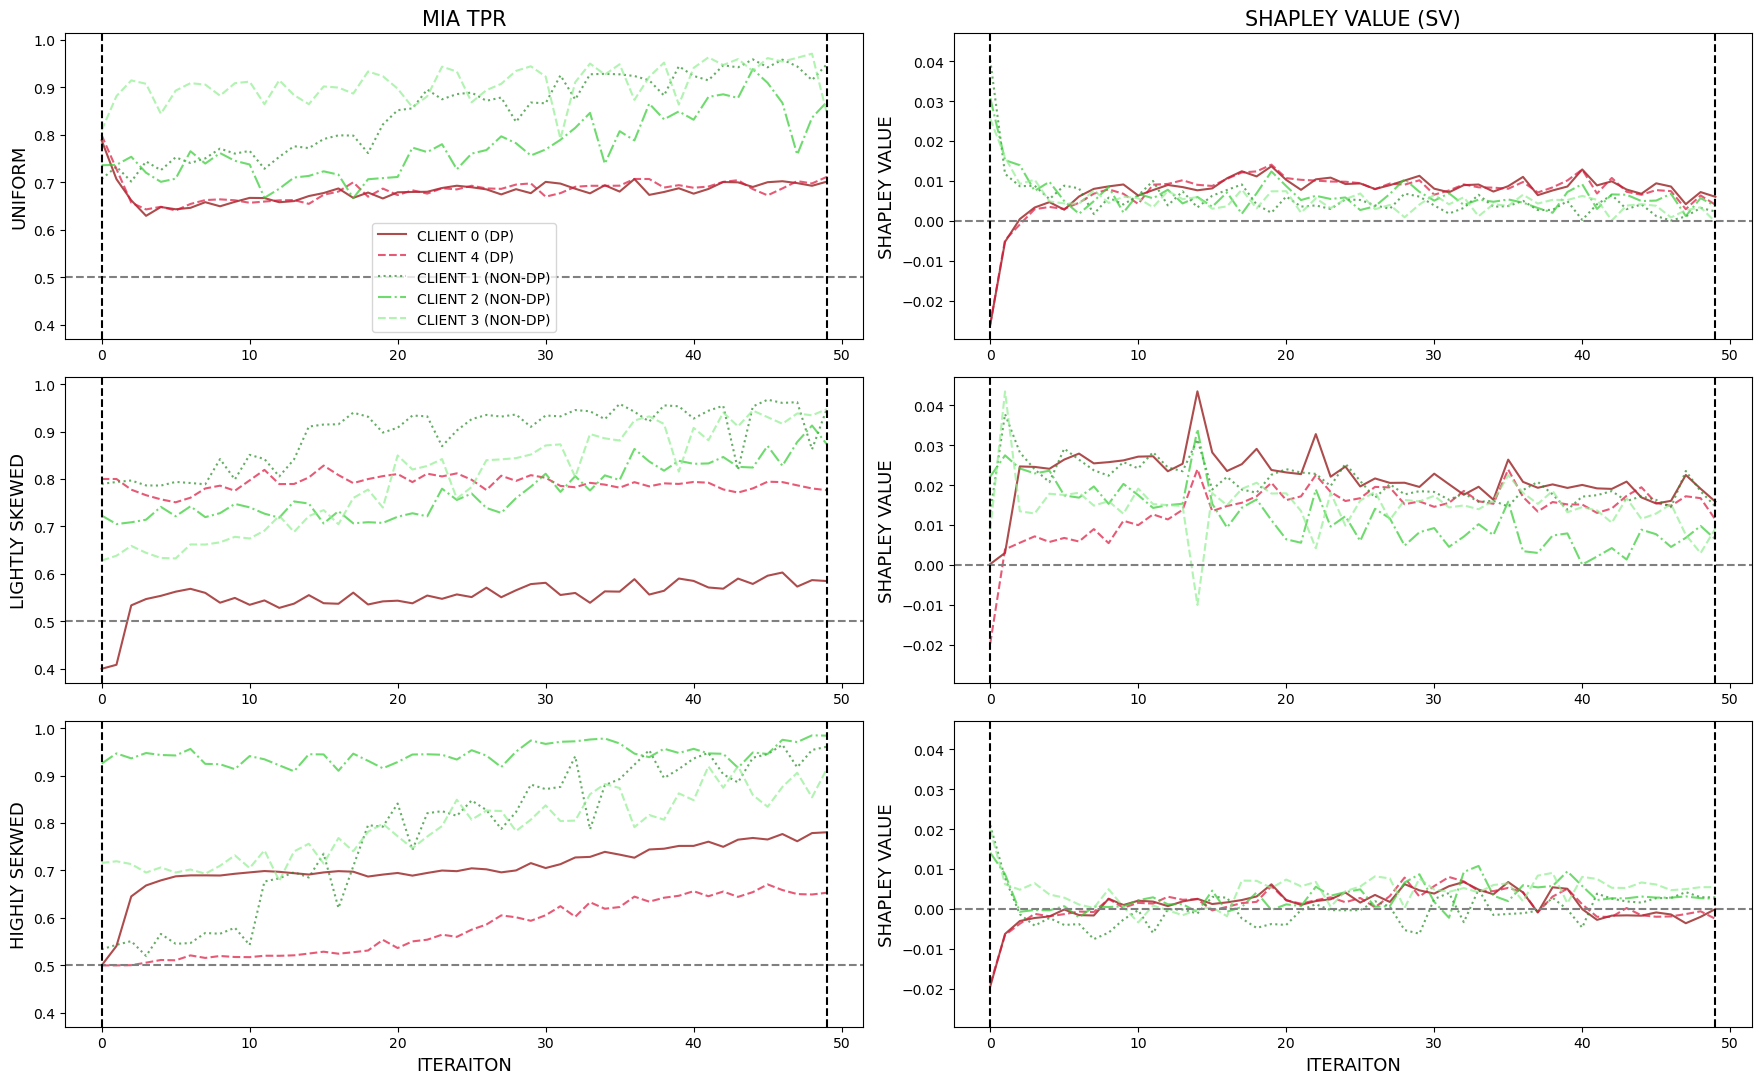

In [19]:
datasets = ['cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    4: ('#DC143C', '--'),  # Crimson Red (Dashed)
    1: ('#228B22', ':'),   # Forest Green (Dotted)
    2: ('#32CD32', '-.'),  # Lime Green (Dash-Dot)
    3: ('#90EE90', '--')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 2, figsize=GENERAL_RATIO)
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 4]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [1, 2, 3]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
    
        axes[0,0].legend()
        axes[0,0].set_title("MIA TPR", fontsize=TITLE_FONT)
        axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=TITLE_FONT)

        axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=Y_LABEL_FONT)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=Y_LABEL_FONT)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])

        x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=X_LABEL_FONT)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=X_LABEL_FONT)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)
        fig.tight_layout()

## Part 4.1B (LOO & ALPHA)

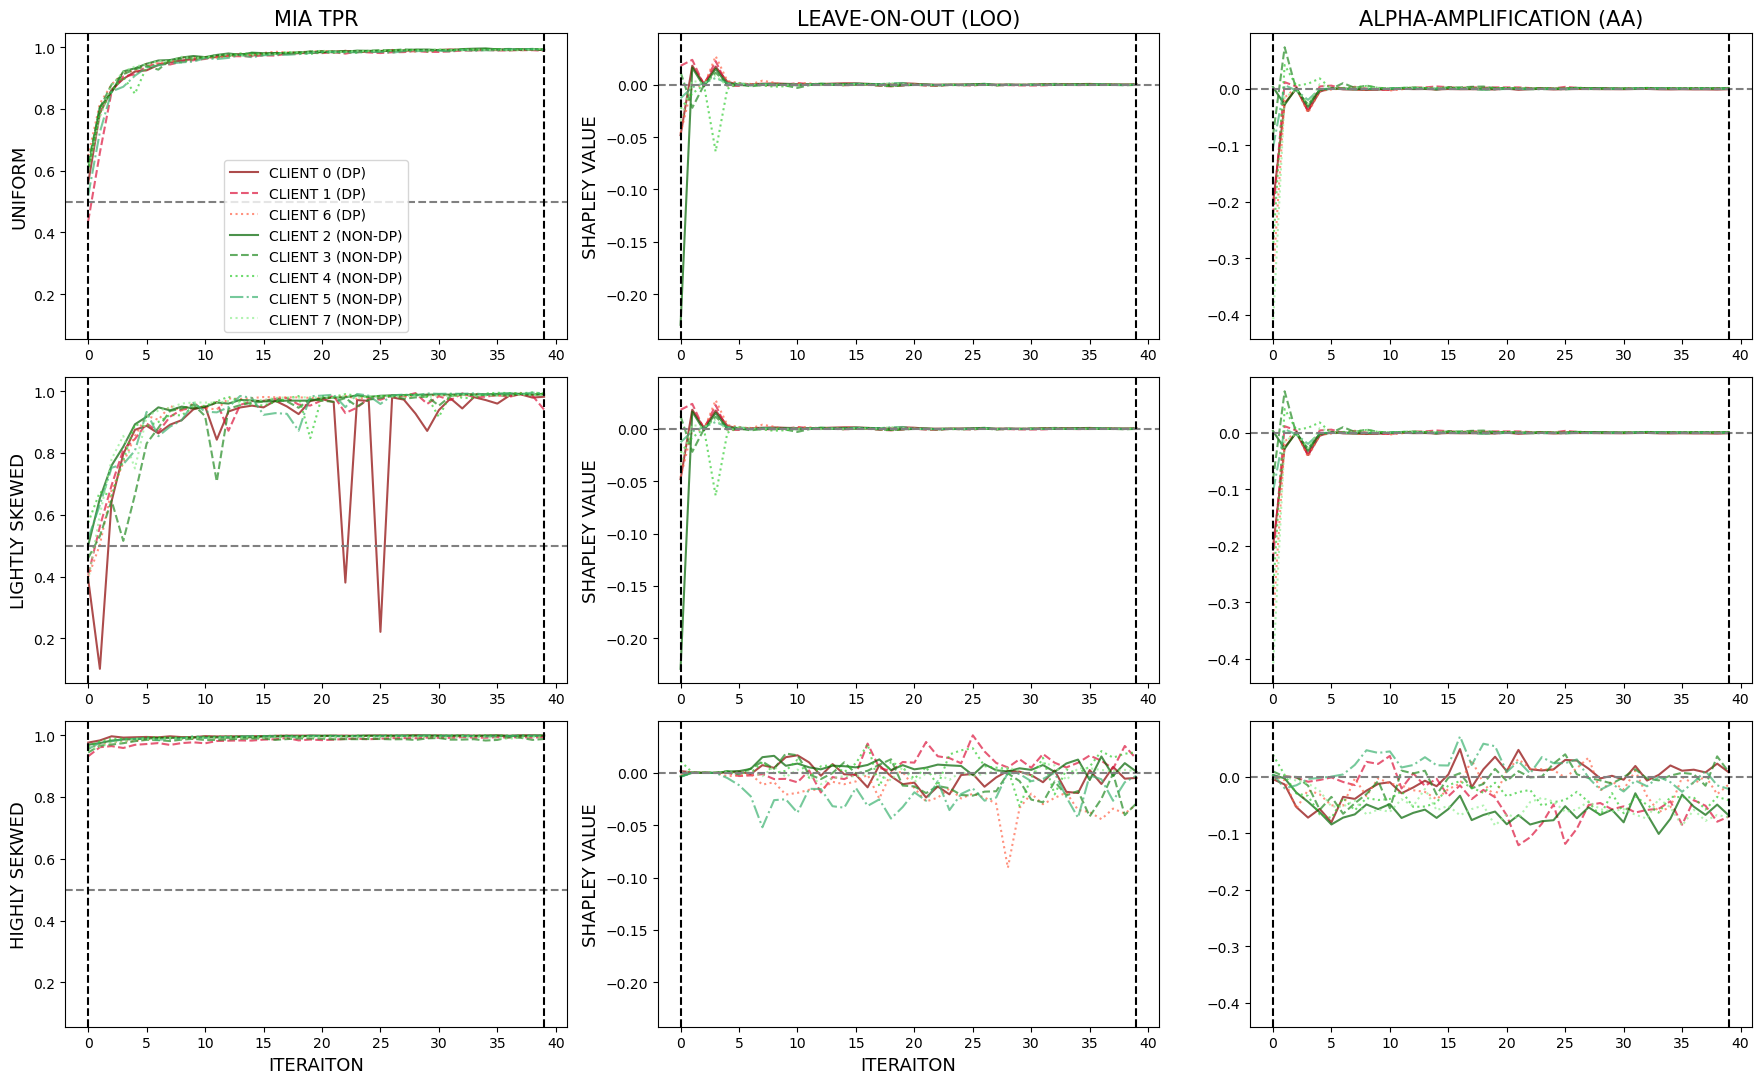

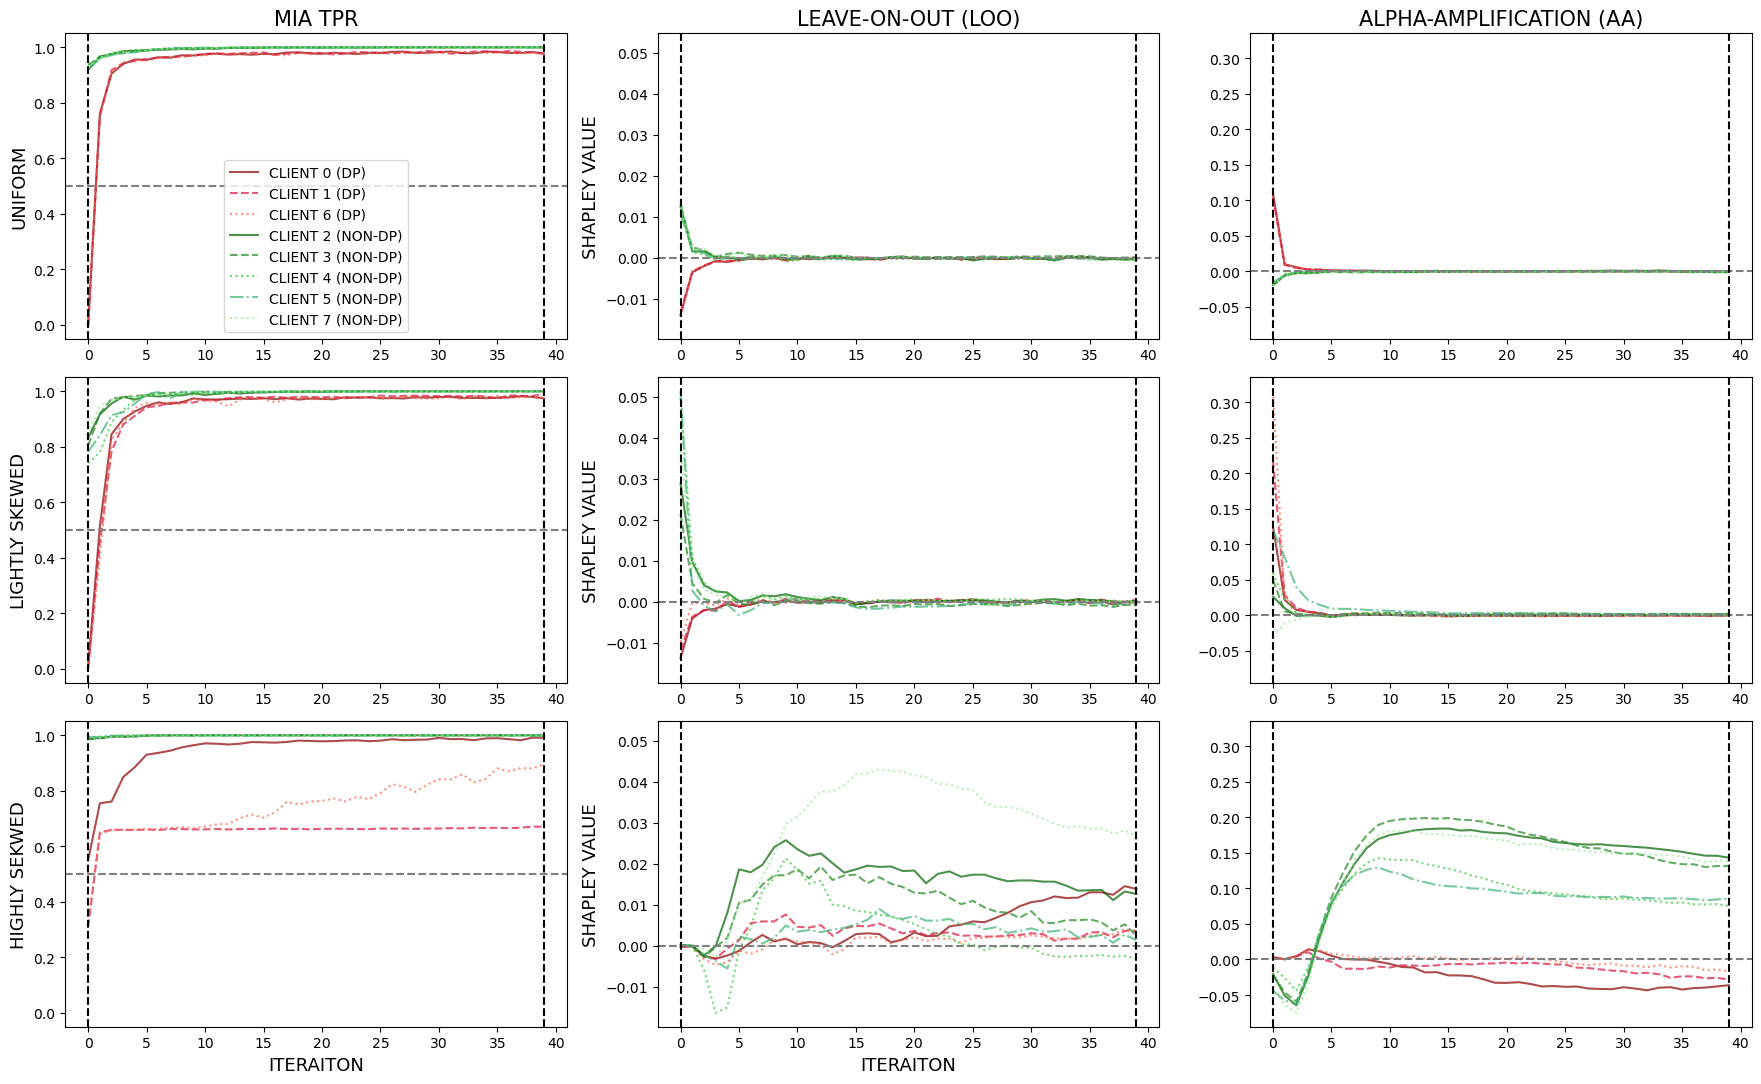

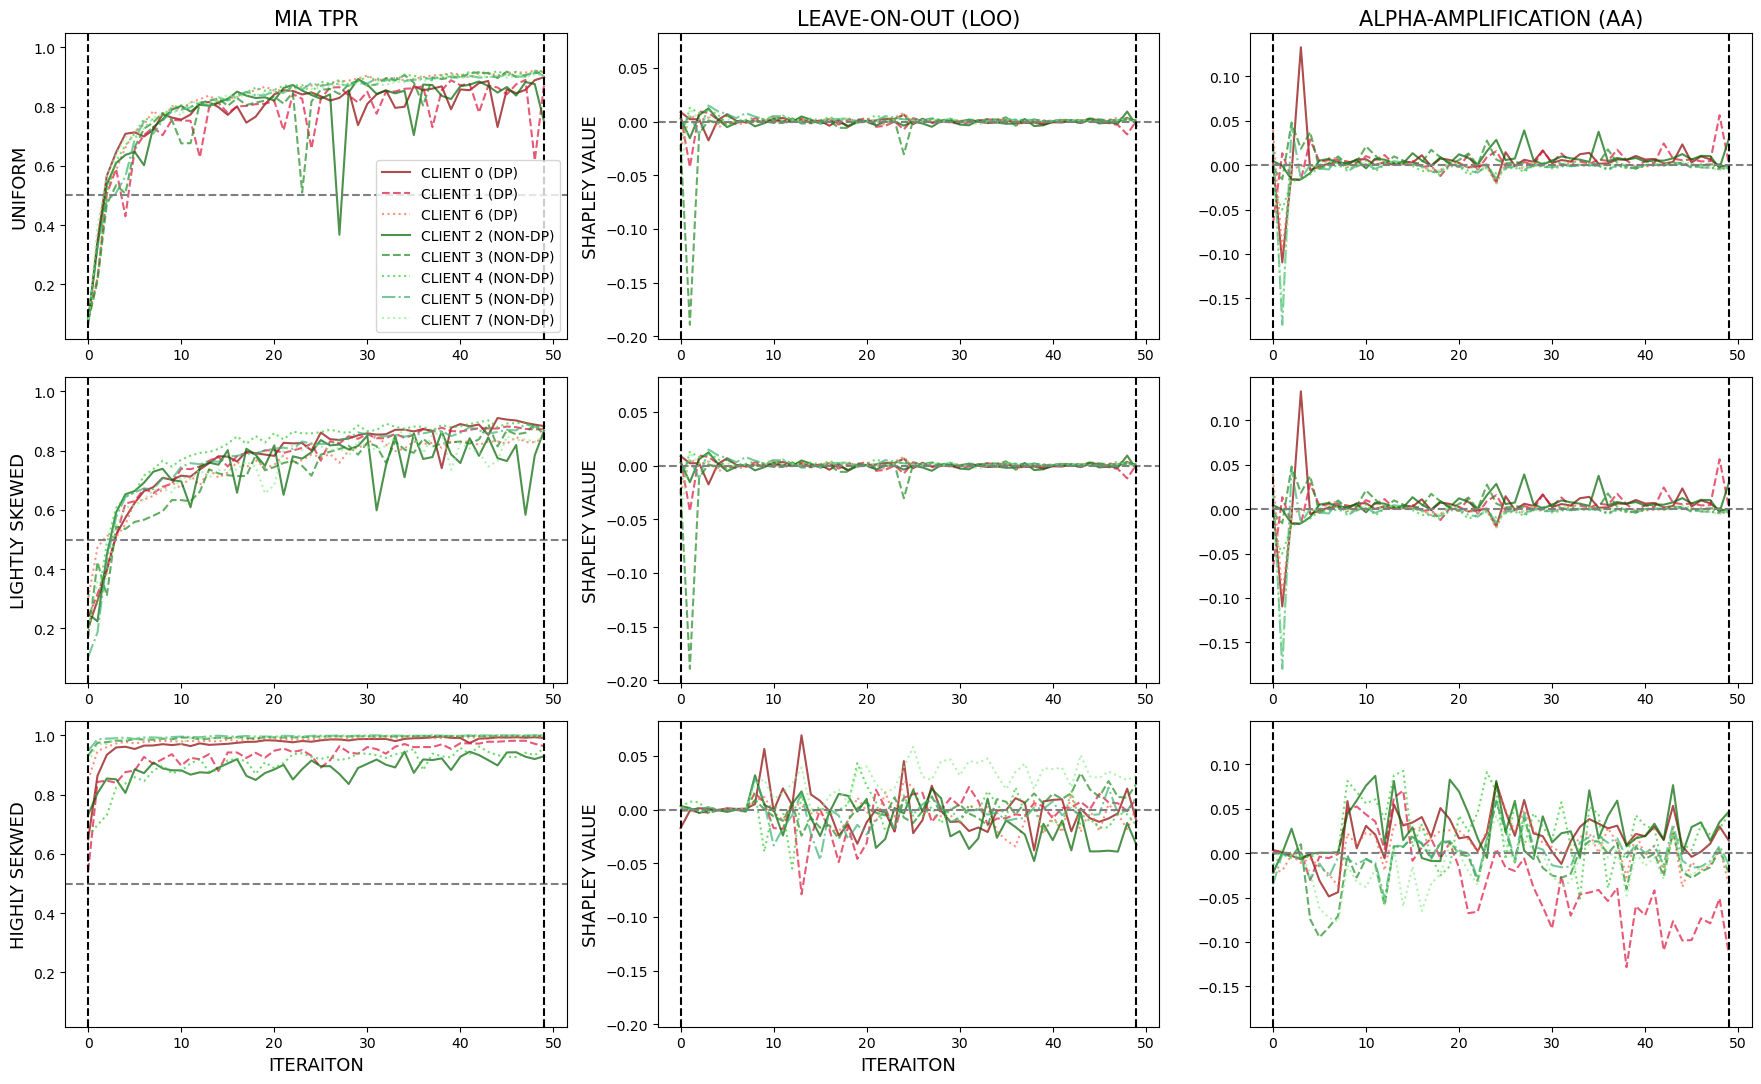

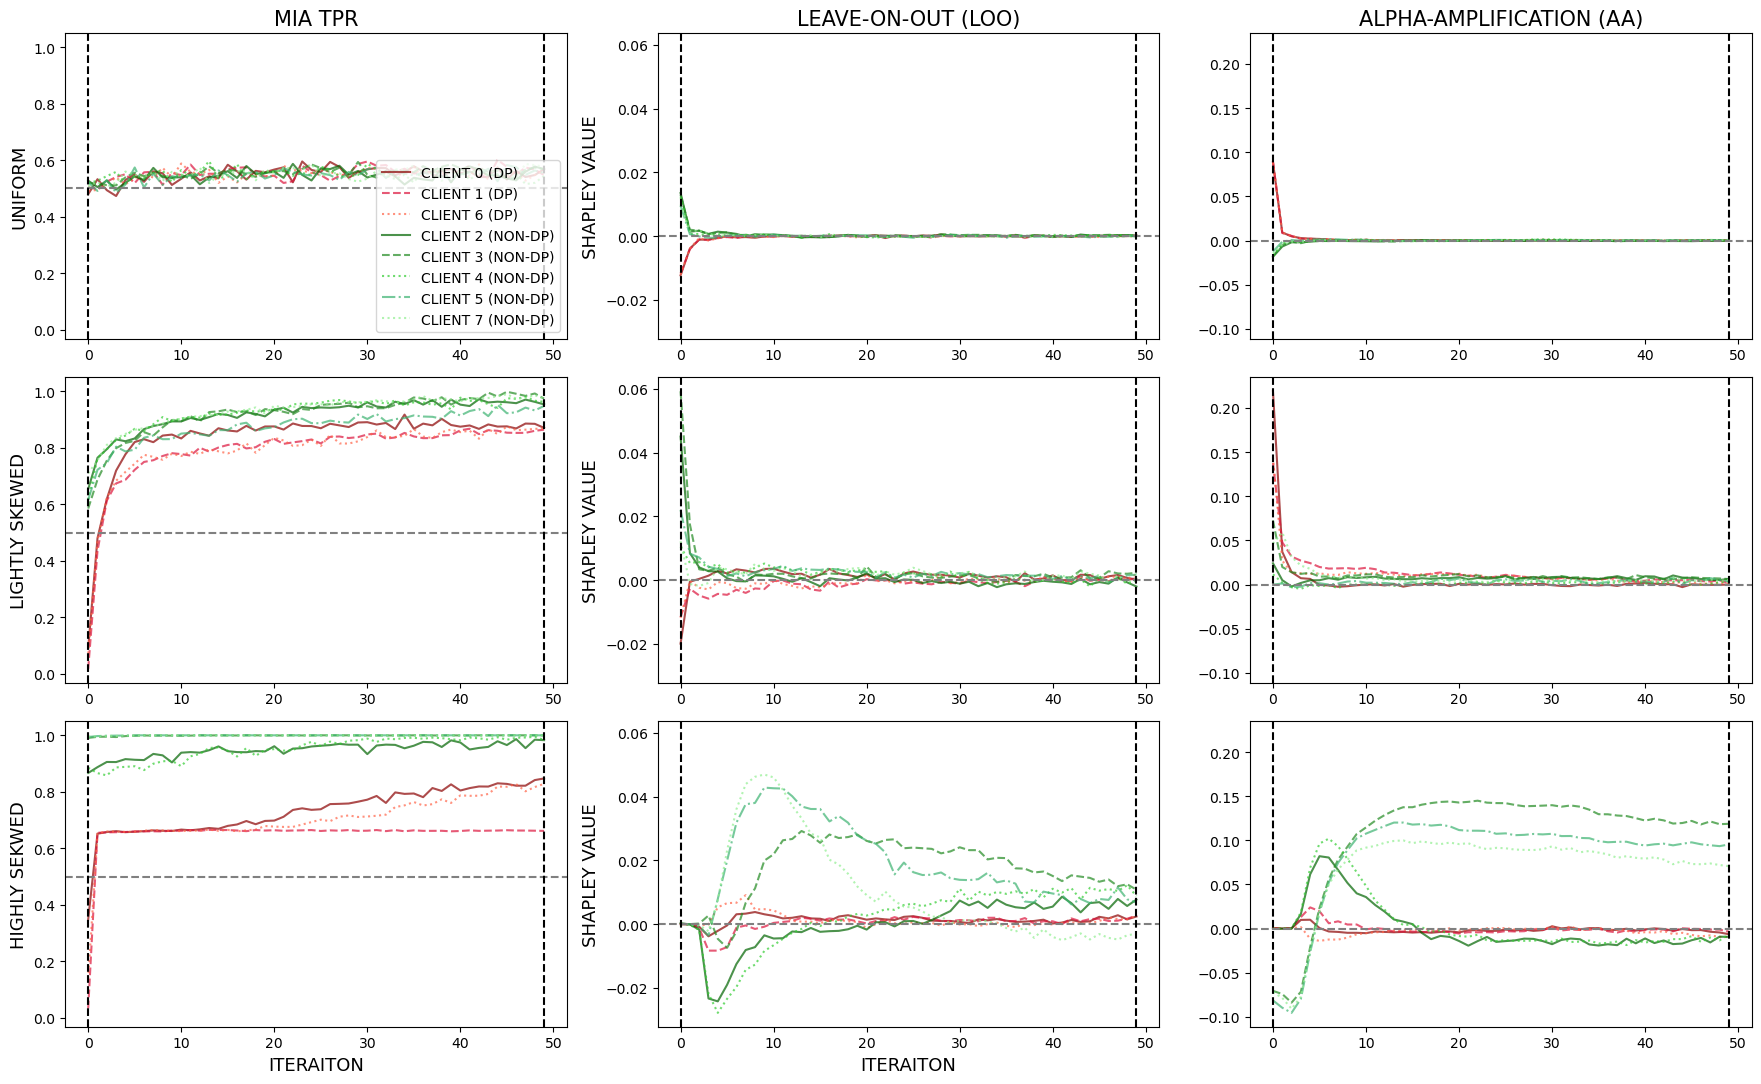

In [20]:
datasets = ['mnist', 'fmnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    1: ('#DC143C', '--'),  # Crimson Red (Dashed)
    6: ('#FF6347', ':'),   # Tomato Red (Dotted)
    2: ('#006400', '-'),   # Dark Green (Solid)
    3: ('#228B22', '--'),  # Forest Green (Dashed)
    4: ('#32CD32', ':'),   # Lime Green (Dotted)
    5: ('#3CB371', '-.'),  # Medium Sea Green (Dash-Dot)
    7: ('#90EE90', ':')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 3, figsize=GENERAL_RATIO)
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 1, 6]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_LOO_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[2].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_ALPHA_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [2, 3, 4, 5, 7]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_LOO_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[2].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_ALPHA_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')

        axes[0,0].legend()
        axes[0,0].set_title("MIA TPR", fontsize=TITLE_FONT)
        axes[0,1].set_title("LEAVE-ON-OUT (LOO)", fontsize=TITLE_FONT)
        axes[0,2].set_title("ALPHA-AMPLIFICATION (AA)", fontsize=TITLE_FONT)

        axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=Y_LABEL_FONT)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=Y_LABEL_FONT)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])
        axes[1][2].sharey(axes[0][2])
        axes[2][2].sharey(axes[0][2])

        if dataset == 'mnist':
            x = 39
        else:
            x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][2].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
            axes[i][2].axvline(x=0, color='black', linestyle='--')
            axes[i][2].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=X_LABEL_FONT)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=Y_LABEL_FONT)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)
        fig.tight_layout()

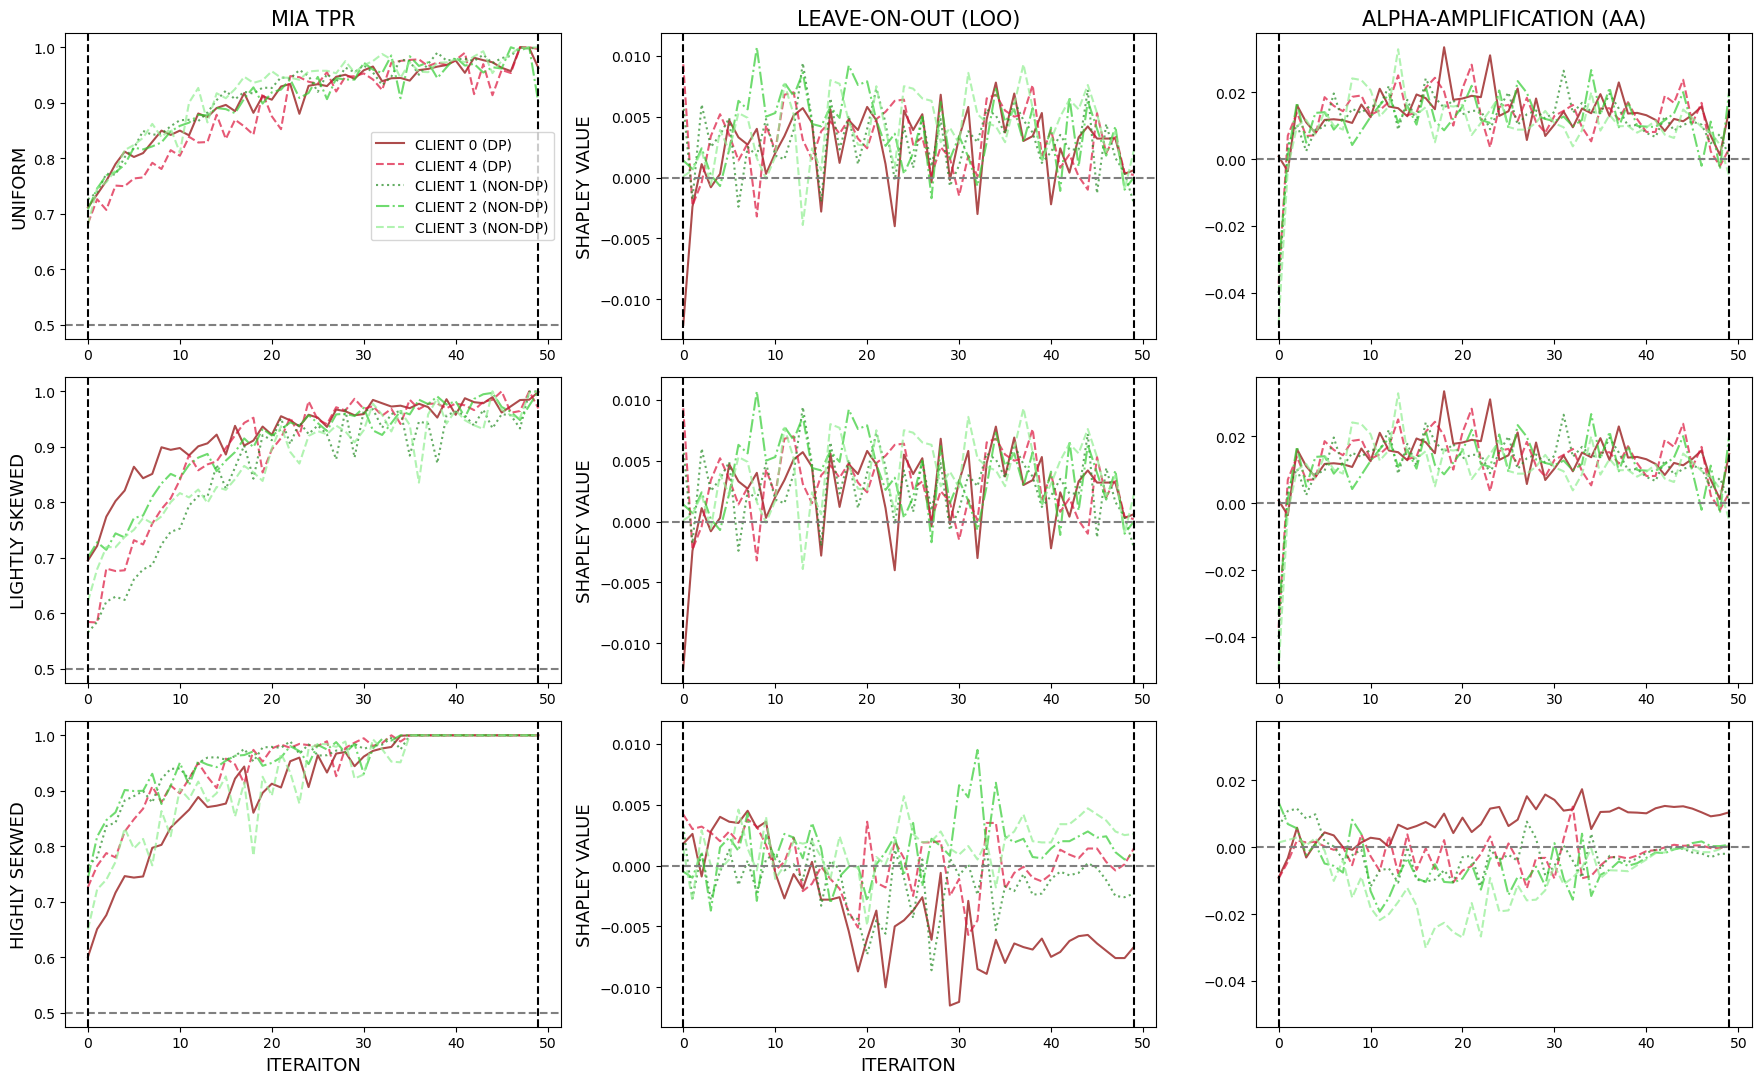

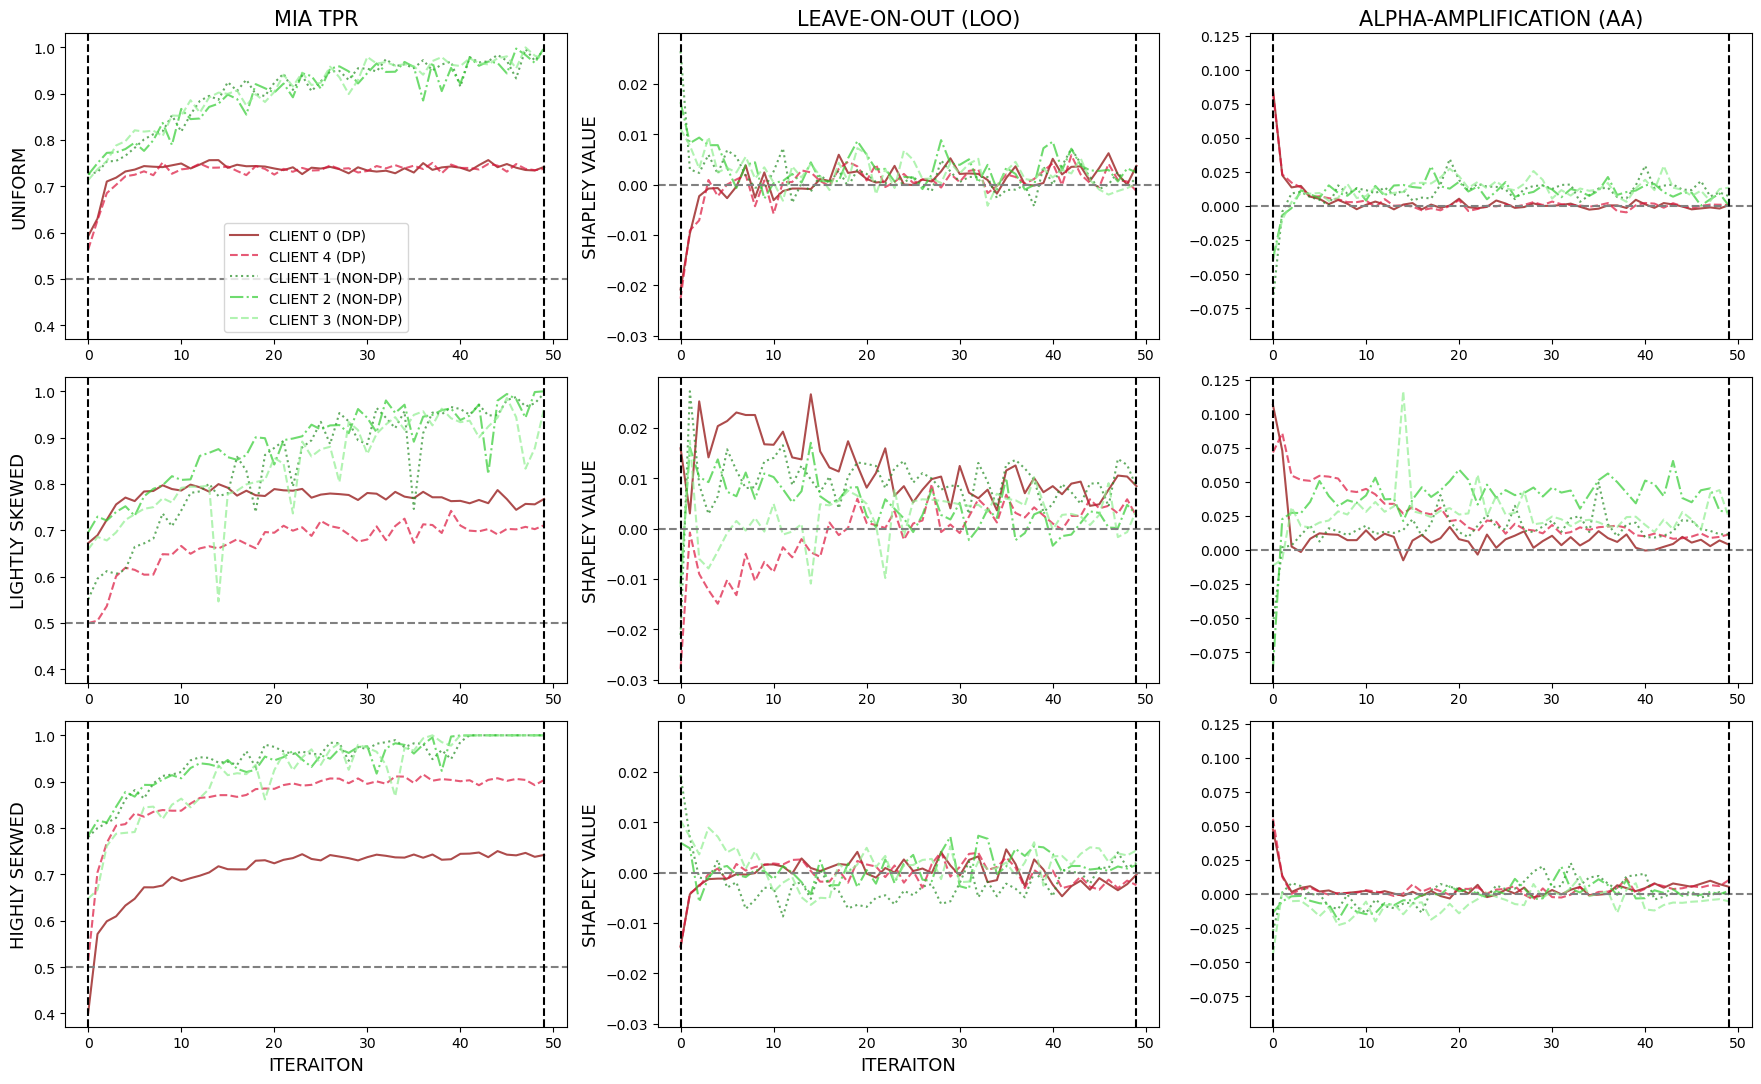

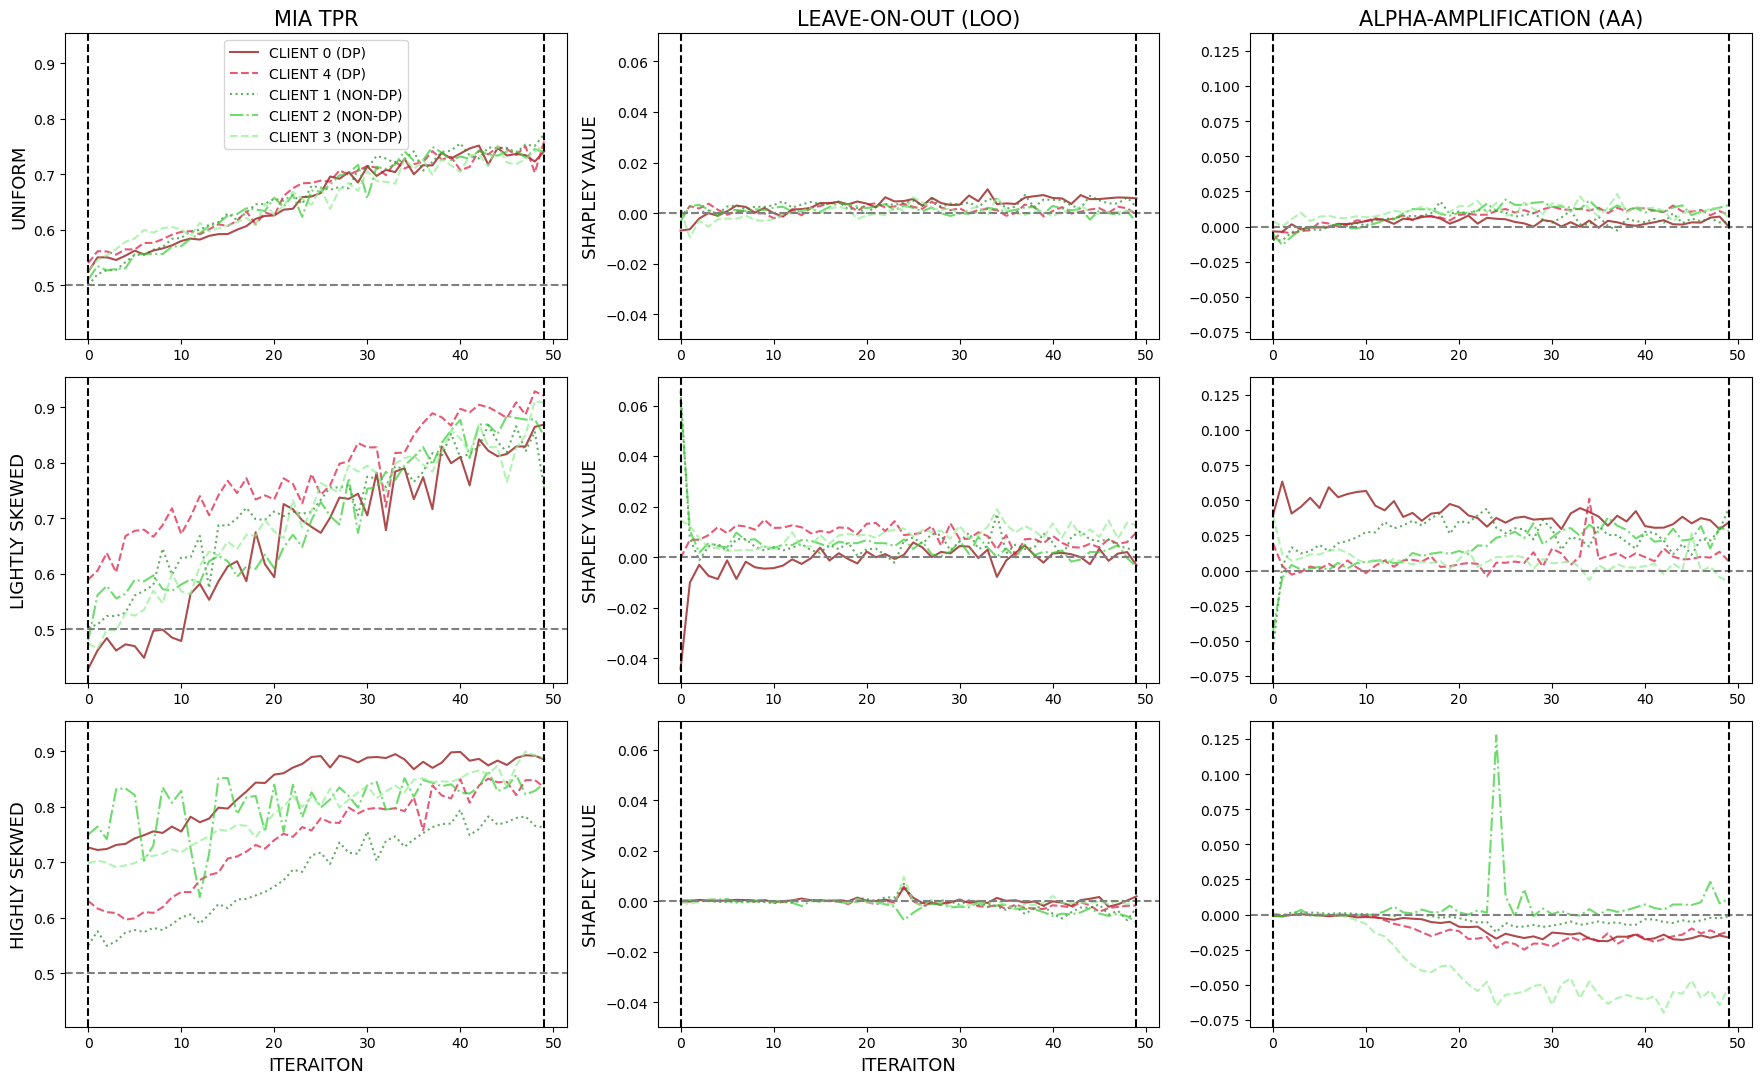

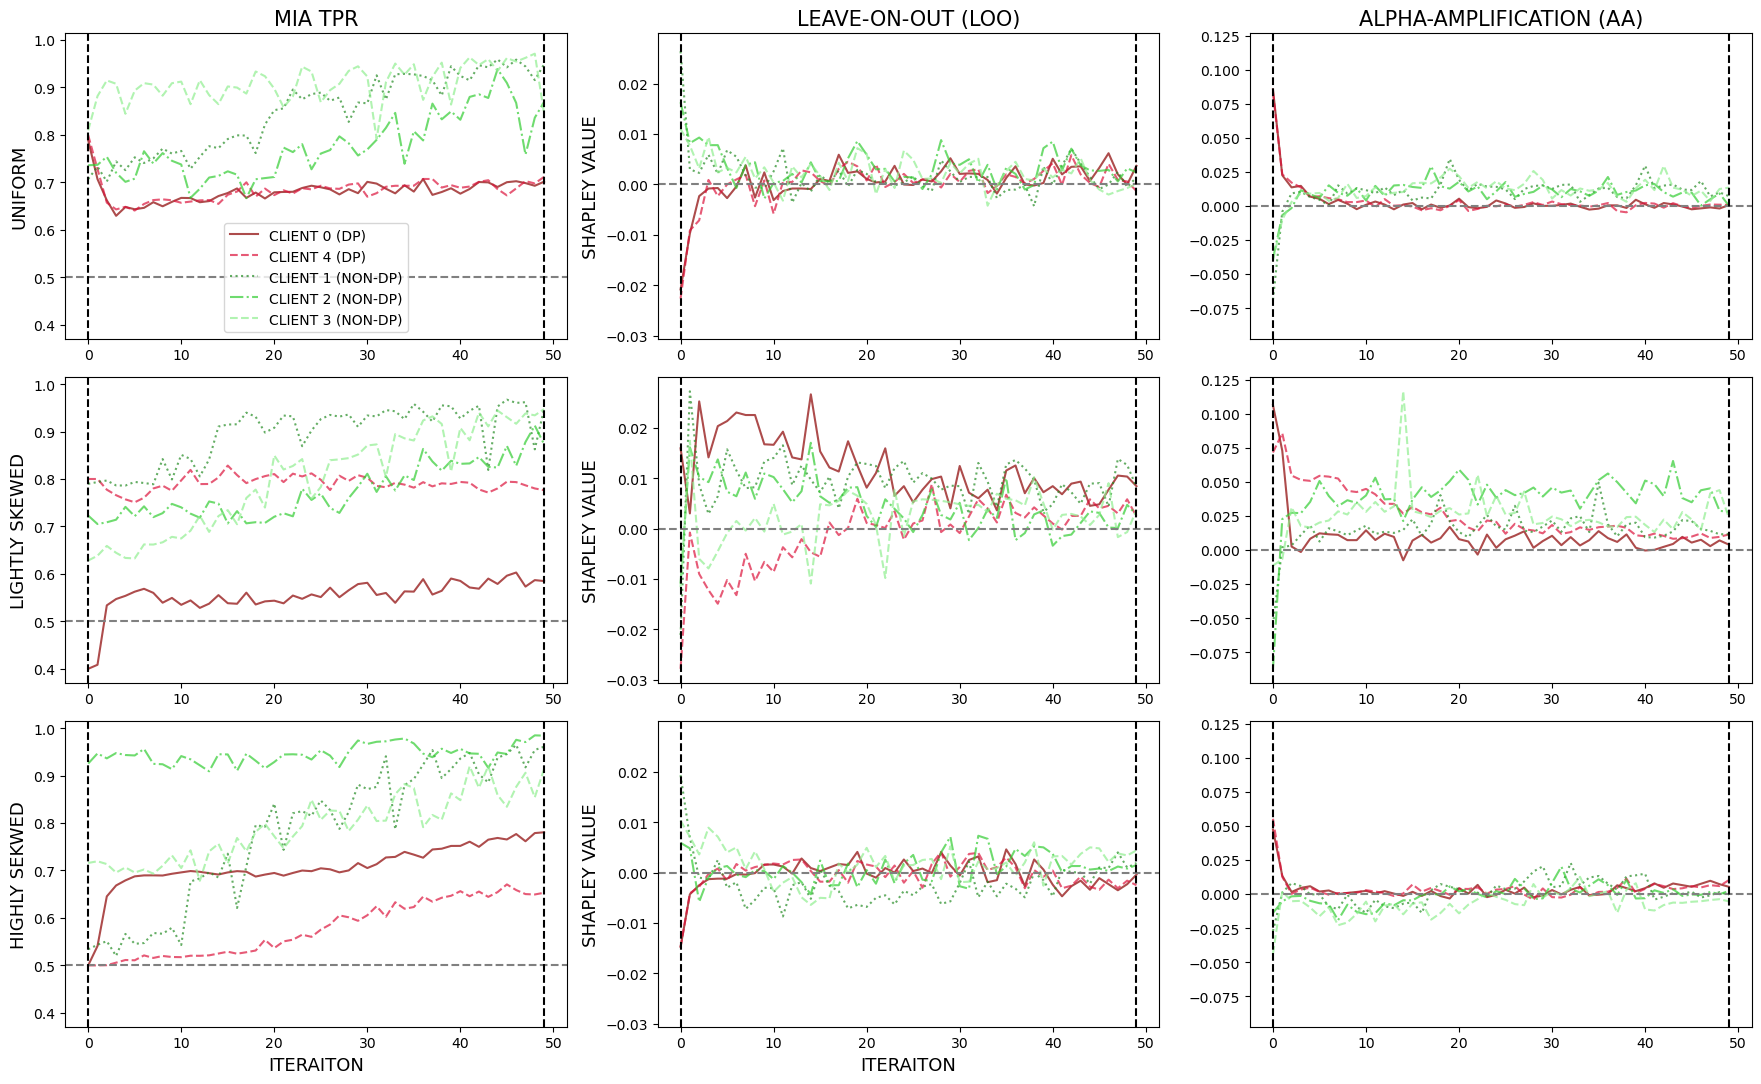

In [21]:
datasets = ['cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    4: ('#DC143C', '--'),  # Crimson Red (Dashed)
    1: ('#228B22', ':'),   # Forest Green (Dotted)
    2: ('#32CD32', '-.'),  # Lime Green (Dash-Dot)
    3: ('#90EE90', '--')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 3, figsize=GENERAL_RATIO)
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 4]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_LOO_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[2].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_ALPHA_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [1, 2, 3]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_LOO_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[2].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_ALPHA_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')

        axes[0,0].legend()
        axes[0,0].set_title("MIA TPR", fontsize=TITLE_FONT)
        axes[0,1].set_title("LEAVE-ON-OUT (LOO)", fontsize=TITLE_FONT)
        axes[0,2].set_title("ALPHA-AMPLIFICATION (AA)", fontsize=TITLE_FONT)

        axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=Y_LABEL_FONT)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=Y_LABEL_FONT)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])
        axes[1][2].sharey(axes[0][2])
        axes[2][2].sharey(axes[0][2])

        if dataset == 'mnist':
            x = 39
        else:
            x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][2].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
            axes[i][2].axvline(x=0, color='black', linestyle='--')
            axes[i][2].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=X_LABEL_FONT)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=Y_LABEL_FONT)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)
        fig.tight_layout()

# Part 4.2.: Visual Inspection of the Relationship (averaged)

# Part 4.2A: SV

In [1]:
# datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
# scenarios = ['uniform', 'ls', 'hs']
# versions = ['without_DP']

# client_styles = {
#     'mnist': '-',  # Blue
#     'fmnist': '--', # Red 
#     'cifar10-5': ':',  # Green 
#     'tissuemnist': '-.', # Orange 
# }


# results = load_multiple_contribution_attack_results(
#             datasets=datasets,
#             scenarios=scenarios,
#             versions=versions
# )
# fig, axes = plt.subplots(3, 2, figsize=GENERAL_RATIO)

# for dataset in datasets:
#     if dataset == 'mnist' or dataset == 'fmnist':
#         dp_clients = [0, 1, 6]
#         non_dp_clients = [2, 3, 4, 5, 7]
#     else:
#         dp_clients = [0, 4]
#         non_dp_clients = [1, 2, 3]
    
#     axes[0][0].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset], label=f"{dataset} (DP)".upper())
#     axes[1][0].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][0].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][0].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset], label=f"{dataset} (NON DP)".upper())
#     axes[1][0].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][0].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     axes[0][1].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[1][1].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][1].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][1].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[1][1].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][1].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     axes[0,0].legend()
#     axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=TITLE_FONT)
#     axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=TITLE_FONT)

#     axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
#     axes[1,0].set_ylabel('LS', fontsize=Y_LABEL_FONT)
#     axes[2,0].set_ylabel('HS', fontsize=Y_LABEL_FONT)

#     axes[1][0].sharey(axes[0][0])
#     axes[2][0].sharey(axes[0][0])
#     axes[1][1].sharey(axes[0][1])
#     axes[2][1].sharey(axes[0][1])

# x = 49
# for i in range(3):
#     axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
#     axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
#     axes[i][0].axvline(x=0, color='black', linestyle='--')
#     axes[i][0].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][0].axvline(x=x, color='black', linestyle='--')
#     axes[i][0].text(38, axes[i][0].get_ylim()[1] * 0.5, 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][0].text(48, axes[i][0].get_ylim()[1] * 0.5, 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][1].axvline(x=0, color='black', linestyle='--')
#     axes[i][1].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][1].axvline(x=x, color='black', linestyle='--')
#     axes[i][1].text(38, axes[i][1].get_ylim()[1] * (-1), 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][1].text(48, axes[i][1].get_ylim()[1] * (-1), 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
# for i in range(2):
#     axes[2][i].set_xlabel("ITERAITON")
# for i in range(3):
#     axes[i][1].set_ylabel("SHAPLEY VALUE")

# if version == 'with_DP':
#     suptitle = "(SOME CLIENTS WITH DP)"
# else:
#     suptitle = "(WITHOUT ANY DP)"
# #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

# fig.tight_layout()

In [2]:
# datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
# scenarios = ['uniform', 'ls', 'hs']
# versions = ['with_DP']

# client_styles = {
#     'mnist': '-',  # Blue
#     'fmnist': '--', # Red 
#     'cifar10-5': ':',  # Green 
#     'tissuemnist': '-.', # Orange 
# }


# results = load_multiple_contribution_attack_results(
#             datasets=datasets,
#             scenarios=scenarios,
#             versions=versions
# )
# fig, axes = plt.subplots(3, 2, figsize=GENERAL_RATIO)

# for dataset in datasets:
#     if dataset == 'mnist' or dataset == 'fmnist':
#         dp_clients = [0, 1, 6]
#         non_dp_clients = [2, 3, 4, 5, 7]
#     else:
#         dp_clients = [0, 4]
#         non_dp_clients = [1, 2, 3]
    
#     axes[0][0].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset], label=f"{dataset} (DP)".upper())
#     axes[1][0].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][0].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][0].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset], label=f"{dataset} (NON DP)".upper())
#     axes[1][0].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][0].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     axes[0][1].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[1][1].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][1].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][1].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[1][1].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][1].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     axes[0,0].legend()
#     axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=TITLE_FONT)
#     axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=TITLE_FONT)

#     axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
#     axes[1,0].set_ylabel('LS', fontsize=Y_LABEL_FONT)
#     axes[2,0].set_ylabel('HS', fontsize=Y_LABEL_FONT)

#     axes[1][0].sharey(axes[0][0])
#     axes[2][0].sharey(axes[0][0])
#     axes[1][1].sharey(axes[0][1])
#     axes[2][1].sharey(axes[0][1])

# x = 49
# for i in range(3):
#     axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
#     axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
#     axes[i][0].axvline(x=0, color='black', linestyle='--')
#     axes[i][0].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][0].axvline(x=x, color='black', linestyle='--')
#     axes[i][0].text(38, axes[i][0].get_ylim()[1] * 0.20, 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][0].text(48, axes[i][0].get_ylim()[1] * 0.20, 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][1].axvline(x=0, color='black', linestyle='--')
#     axes[i][1].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][1].axvline(x=x, color='black', linestyle='--')
#     axes[i][1].text(38, axes[i][1].get_ylim()[1] * (-0.2), 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][1].text(48, axes[i][1].get_ylim()[1] * (-0.2), 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
# for i in range(2):
#     axes[2][i].set_xlabel("ITERAITON")
# for i in range(3):
#     axes[i][1].set_ylabel("SHAPLEY VALUE")

# if version == 'with_DP':
#     suptitle = "(SOME CLIENTS WITH DP)"
# else:
#     suptitle = "(WITHOUT ANY DP)"
# #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

# fig.tight_layout()

# Part 4.2B: Leave-one-out (LOO) and Alpha-Amplification (AA)

In [3]:
# datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
# scenarios = ['uniform', 'ls', 'hs']
# versions = ['without_DP']

# client_styles = {
#     'mnist': '-',  # Blue
#     'fmnist': '--', # Red 
#     'cifar10-5': ':',  # Green 
#     'tissuemnist': '-.', # Orange 
# }

# results = load_multiple_contribution_attack_results(
#             datasets=datasets,
#             scenarios=scenarios,
#             versions=versions
# )
# fig, axes = plt.subplots(3, 3, figsize=GENERAL_RATIO)

# for dataset in datasets:
#     if dataset == 'mnist' or dataset == 'fmnist':
#         dp_clients = [0, 1, 6]
#         non_dp_clients = [2, 3, 4, 5, 7]
#     else:
#         dp_clients = [0, 4]
#         non_dp_clients = [1, 2, 3]
    
#     # TPR
#     axes[0][0].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset], label=f"{dataset} (DP)".upper())
#     axes[1][0].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][0].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][0].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset], label=f"{dataset} (NON DP)".upper())
#     axes[1][0].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][0].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     # LOO
#     axes[0][1].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_LOO_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[1][1].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_LOO_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][1].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_LOO_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][1].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_LOO_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[1][1].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_LOO_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][1].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_LOO_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     # ALPHA
#     axes[0][2].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_ALPHA_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[1][2].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_ALPHA_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
#     axes[2][2].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_ALPHA_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
#     axes[0][2].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_ALPHA_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[1][2].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_ALPHA_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
#     axes[2][2].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_ALPHA_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
#     axes[0,0].legend()
#     axes[0,0].set_title("MIA TPR", fontsize=TITLE_FONT)
#     axes[0,1].set_title("LEAVE-ONE-OUT (LOO)", fontsize=TITLE_FONT)
#     axes[0,2].set_title("ALPHA-AMPLIFICATION (AA)", fontsize=TITLE_FONT)

#     axes[0,0].set_ylabel('UNIFORM', fontsize=Y_LABEL_FONT)
#     axes[1,0].set_ylabel('LS', fontsize=Y_LABEL_FONT)
#     axes[2,0].set_ylabel('HS', fontsize=Y_LABEL_FONT)

#     axes[1][0].sharey(axes[0][0])
#     axes[2][0].sharey(axes[0][0])
#     axes[1][1].sharey(axes[0][1])
#     axes[2][1].sharey(axes[0][1])
#     axes[1][2].sharey(axes[0][2])
#     axes[2][2].sharey(axes[0][2])

# x = 49
# for i in range(3):
#     axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
#     axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
#     axes[i][2].axhline(y=0.0, color='gray', linestyle='--')
    
#     # FIRST COLUMNS
#     axes[i][0].axvline(x=0, color='black', linestyle='--')
#     axes[i][0].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][0].axvline(x=x, color='black', linestyle='--')
#     axes[i][0].text(38, axes[i][0].get_ylim()[1] * 0.5, 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][0].text(48, axes[i][0].get_ylim()[1] * 0.5, 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
    
#     # SECOND COLUMNS
#     axes[i][1].axvline(x=0, color='black', linestyle='--')
#     axes[i][1].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][1].axvline(x=x, color='black', linestyle='--')
#     axes[i][1].text(38, axes[i][1].get_ylim()[1] * (-0.5), 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][1].text(48, axes[i][1].get_ylim()[1] * (-0.5), 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
    
#     # THIRD COLUMN
#     axes[i][2].axvline(x=0, color='black', linestyle='--')
#     axes[i][2].axvline(x=39, color='black', linestyle='--', alpha=0.5)
#     axes[i][2].axvline(x=x, color='black', linestyle='--')
#     axes[i][2].text(38, axes[i][2].get_ylim()[1] * (-1.25), 'ROUND 39', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
#     axes[i][2].text(48, axes[i][2].get_ylim()[1] * (-1.25), 'ROUND 49', 
#                     color='black', fontsize=ANOT_FONT, ha='center', va='center', rotation=90)
    
# for i in range(2):
#     axes[2][i].set_xlabel("ITERAITON")
# for i in range(3):
#     axes[i][1].set_ylabel("SHAPLEY VALUE")

# if version == 'with_DP':
#     suptitle = "(SOME CLIENTS WITH DP)"
# else:
#     suptitle = "(WITHOUT ANY DP)"
# #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

# fig.tight_layout()

# 5.3.2. Stationarity Analysis

In [22]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']

versions = ['with_DP', 'without_DP']

results= load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    for scenario in scenarios:
        for version in versions:
            if dataset == 'mnist' or dataset == 'fmnist':
                no_clients = 8
            else:
                no_clients = 5
            stats = calculate_single_stationarity(
                no_clients=no_clients,
                frame=results[f"{scenario}_{version}_{dataset}"]
            )
            root = os.path.join(os.getcwd(), 'tables', 'stationarity')
            stats = stats.round(2)
            with open(os.path.join(root, f"{scenario}_{version}_{dataset}.tex"), 'w') as file:
                file.write(stats.to_latex(float_format="%.2f"))

c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr /

# 5.3.3. Correlation Tests (Pearson)

In [29]:
metrics = ["SHAP", "LOO", "ALPHA"]
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['with_DP', 'without_DP']

results= load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for metric in metrics:
    for dataset in datasets:
        if dataset == 'mnist' or dataset == 'fmnist':
            no_clients = 8
        else:
            no_clients = 5
        for version in versions:
            correlation_tests = pd.DataFrame(index=range(no_clients), columns=['uniform coef', 'uniform p-value', 'ls coef', 'ls p-value', 'hs coef', 'hs p-value'])
            for scenario in scenarios:
                stats = calculate_single_corr_short(
                    no_clients = no_clients,
                    frame = results[f"{scenario}_{version}_{dataset}"],
                    mode ='pearson'
                )
                correlation_tests[f"{scenario} coef"] = stats[f'TPR_TO_{metric}_F1SCORE']
                correlation_tests[f"{scenario} p-value"] = stats[f'TPR_TO_{metric}_F1SCORE P-VALUE']
            correlation_tests = correlation_tests.round(2)
            root = os.path.join(os.getcwd(), 'tables', 'correlations', 'pearson', metric)
            with open(os.path.join(root, f"{version}_{dataset}.tex"), 'w') as file:
                file.write(correlation_tests.to_latex(float_format="%.2f"))

# 5.3.3. Correlation Tests (Spearmann)

In [30]:
metrics = ["SHAP", "LOO", "ALPHA"]
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['with_DP', 'without_DP']

results= load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for metric in metrics:
    for dataset in datasets:
        if dataset == 'mnist' or dataset == 'fmnist':
            no_clients = 8
        else:
            no_clients = 5
        for version in versions:
            correlation_tests = pd.DataFrame(index=range(no_clients), columns=['uniform coef', 'uniform p-value', 'ls coef', 'ls p-value', 'hs coef', 'hs p-value'])
            for scenario in scenarios:
                stats = calculate_single_corr_short(
                    no_clients = no_clients,
                    frame = results[f"{scenario}_{version}_{dataset}"],
                    mode ='spearman'
                )
                correlation_tests[f"{scenario} coef"] = stats[f'TPR_TO_{metric}_F1SCORE']
                correlation_tests[f"{scenario} p-value"] = stats[f'TPR_TO_{metric}_F1SCORE P-VALUE']
            correlation_tests = correlation_tests.round(2)
            root = os.path.join(os.getcwd(), 'tables', 'correlations', 'spearman', metric)
            with open(os.path.join(root, f"{version}_{dataset}.tex"), 'w') as file:
                file.write(correlation_tests.to_latex(float_format="%.2f"))

# 5.3.4. Cross-Correlation Tests

In [ ]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['with_DP']

client_styles = {
    0: ('#E6194B', '-'),   # Red (Solid)
    1: ('#FF7F0E', '--'),  # Dark Orange (Dashed)
    2: ('#FFD700', ':'),   # Golden Yellow (Dotted)
    3: ('#FF6347', '-.'),  # Tomato Red (Dash-Dot)
    4: ('#1F77B4', '-'),   # Blue (Solid)
    5: ('#17BECF', '--'),  # Teal (Dashed)
    6: ('#9467BD', ':'),   # Purple (Dotted)
    7: ('#2CA02C', '-.')   # Dark Green (Dash-Dot)
}

with_DP = load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    fig, axes = plt.subplots(2, 3, figsize=(15, 15), sharex=True, sharey=True)
    if dataset == 'mnist' or dataset == 'fmnist':
        dp_clients = [0, 1, 6]
        non_dp_clients = [2, 3, 4, 5, 7]
        client_styles = {
            0: ('#1F77B4', '--'),   # Blue (Dashed)
            1: ('#D62728', '--'),   # Red (Dashed)
            2: ('#1F77B4', '--'),   # Blue (Dashed)
            3: ('#D62728', '-.'),   # Red (Dash-Dot)
            4: ('#2CA02C', '-.'),   # Green (Dash-Dot)
            5: ('#FF7F0E', '-'),   # Orange (Solid)
            6: ('#2CA02C', '-'),    # Green (Solid)
            7: ('#9467BD', '-')    # Purple (Solid)
        }
    else:
        dp_clients = [0, 4]
        non_dp_clients = [1, 2, 3]
        client_styles = {
            0: ('#1F77B4', '--'),  # Blue (Dashed)
            1: ('#1F77B4', '--'),  # Blue (Dashed)
            2: ('#D62728', ':'),   # Red (Dot)
            3: ('#2CA02C', '-.'),  # Tomato Red (Dash-Dot)
            4: ('#D62728', '--'),   # Red (Dashed)
        }
    for index, scenario in enumerate(scenarios):
        alpha = 0.75
        for client in dp_clients:
            series_A = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_TPR"]
            series_B = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_SHAP_F1SCORE"]
            axes[0][index].xcorr(series_A, series_B, maxlags=10, normed=True, color=client_styles[client][0], linestyle=client_styles[client][1], alpha=alpha, label=f'CLIENT {client}')
            alpha += 0.05
        alpha = 0.75
        for client in non_dp_clients:
            series_A = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_TPR"]
            series_B = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_SHAP_F1SCORE"]
            axes[1][index].xcorr(series_A, series_B, maxlags=10, normed=True, color=client_styles[client][0], linestyle=client_styles[client][1], alpha=alpha, label=f'CLIENT {client}')
            alpha += 0.05
        axes[0][index].axvline(x=-10, color='gray', linestyle='--')
        axes[0][index].axvline(x=10, color='gray', linestyle='--')
        axes[1][index].axvline(x=-10, color='gray', linestyle='--')
        axes[1][index].axvline(x=10, color='gray', linestyle='--')
        axes[0][index].axhline(y=0, color='black', linewidth=0.5)
        axes[1][index].axhline(y=0, color='black', linewidth=0.5)
        axes[0][index].set_xlabel("Lag", fontsize = 14)
        axes[1][index].set_xlabel("Lag", fontsize = 14)

    axes[0][0].legend()
    axes[1][0].legend()
    axes[0,0].set_ylabel('DP CLIENTS', fontsize=15)
    axes[1,0].set_ylabel('NON-DP CLIENTS', fontsize=15)
    axes[0,0].set_title("UNIFORM", fontsize=15)
    axes[0,1].set_title("LIGHTLY SKEWED", fontsize=15)
    axes[0,2].set_title("HIGHLY SKEWED", fontsize=15)